<img src = "https://drive.google.com/uc?export=view&id=1z-EW8gVlIg4Zcp_HvN-BElP0KknNnfML" alt = "Encabezado MLDS" width = "100%">  </img>

# **Métodos de clasificación no lineal**
---


En este notebook se discutirán los métodos de clasificación no lineal, y en particular, se presentará la implementación de modelos basados en árboles de decisión y de máquinas de vectores de soporte (SVM). El material se desarrollará con la ayuda de la librería de aprendizaje automático *Scikit-Learn* y de otras librerías comunes como *NumPy*, *Pandas* y *Matplotlib*.

Finalmente, se discutirá la necesidad de identificar los hiperparámetros más adecuados para un modelo de aprendizaje automático, y se discutirán técnicas para estimarlo de forma robusta, como la validación cruzada de $k$ pliegues y  *grid search*.

# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos. 


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería *Scikit-learn* (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [1]:
# Actualizamos scikit-learn a la última versión
!pip install -U scikit-learn 

# Importamos scikit-learn 
import sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importamos además algunas librerías básicas y configuraciones de *Python*.

In [2]:
#Librerías básicas NumPy y Pandas.
import numpy as np
import pandas as pd

#Matplotlib y Seaborn - Librerías de visualización.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de grafos con graphviz.
import graphviz 

In [3]:
# Configuraciones para las librerías y módulos usados.

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)

Este material se realizó con las siguientes versiones:
*  *Python*: 3.7.10
*  *Scikit-learn*: 0.24.1
*  *NumPy*:  1.19.5
*  *Pandas*:  1.1.5
*  *Matplotlib*:  3.2.2
*  *Seaborn*:  0.11.1
*  *Graphviz*: 0.10.1

In [4]:
# Versión de Python y las demás librerías.
!python --version
print('Scikit-learn', sklearn.__version__)
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Graphviz', graphviz.__version__)

Python 3.7.14
Scikit-learn 1.0.2
NumPy 1.21.6
Pandas 1.3.5
Matplotlib 3.2.2
Seaborn 0.11.2
Graphviz 0.10.1


### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos, junto a las funciones de predicción obtenidas con cada modelo.

> **Nota**: *Matplotlib* y *Seaborn* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [5]:
# Función para visualizar un conjunto de datos de dos variables en un plano 2D.
def plot_data(X, y, model = None, ax = None, title=None):

    if ax is None:
      _, ax = plt.subplots(dpi = 110)

    if model is not None: 
      pred_fun = gen_pred_fun(model)
      plot_decision_region(X, pred_fun, ax)

    y_unique = np.unique(y)    
    df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'Clases': y})
    sns.set_theme()
    sns.scatterplot(data = df, x = 'x1', y = 'x2', 
                    hue = 'Clases',style = 'Clases', ax = ax, palette = 'Set1').set_title(title)

In [6]:
# Función para visualizar la superficie de decisión de un clasificador.
def plot_decision_region(X, pred_fun, ax=None):
    min_x, max_x = np.min(X[:, 0]), np.max(X[:, 0])
    min_y, max_y = np.min(X[:, 1]), np.max(X[:, 1])
 
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05

    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)

    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape

    ZZ = np.zeros((grid_r, grid_c))

    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])    
    
    cs = ax.contourf(XX, YY, ZZ, 100, cmap = plt.cm.Pastel1, vmin = 0, vmax = np.max(ZZ)* 9. / (np.max(ZZ) + 1), alpha = 0.75)        
    ax.get_figure().colorbar(cs, ax=ax, )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

In [7]:
# Función para visualizar la curva de aprendizaje a partir 
# del error de entrenamiento y de generalización.
def plot_learning_curve(train_error, generalization_error):
  n = len(train_error)
  if len(train_error) != len(generalization_error):
    print("Las secuencias de error de entrenamiento y generalización deben tener el mismo tamaño.")
    return

  balance_point = np.array(generalization_error).argmin() + 1
  plt.figure(figsize = (8, 5), dpi = 105)

  plt.plot(range(1, n + 1), train_error, label="Entrenamiento")
  plt.plot(range(1, n + 1), generalization_error, label="Generalización")
  plt.xticks(range(0, n + 1, 2))
  plt.xlabel("Profundidad máxima")
  plt.ylabel("Error")
  y_min, y_max = plt.gca().get_ylim() 
  plt.vlines(balance_point, y_min, y_max, colors = ['red'], linestyles = ['dashdot'])
  plt.ylim([y_min, y_max])
  plt.text(balance_point + 1, 0.165, 'Punto de balance')
  plt.legend();

In [8]:
#Función para generar la función de predicción de un clasificador entrenado previamente.
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

# **2. Conjuntos de datos**
---

Para los ejemplos desarrollados en el transcurso del material, se usarán datos de  *Scikit-Learn* de carácter real (usando *Loaders*) y sintético (usando *Generators*).

#### **2.1. Conjunto de datos *Iris***
---

En este material retomaremos el conjunto de datos *Iris* para ilustrar algunos ejemplos. Para esto, usaremos la función **`load_iris`** de *Scikit-Learn*.

In [9]:
# Loader del dataset iris.
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

# También se puede hacer de la forma larga, obteniendo los mismos resultados
#iris = load_iris()
#X = iris.data
#y = iris.target

In [10]:
# Información general del conjunto.

print(f'X ~ {X.shape[0]} muestras x {X.shape[1]} características.')
print(f'y ~ {y.shape[0]} muestras.')
print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:\n', y[:5])

X ~ 150 muestras x 4 características.
y ~ 150 muestras.

Primeras 5 muestras:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

Primeras 5 etiquetas:
 [0 0 0 0 0]


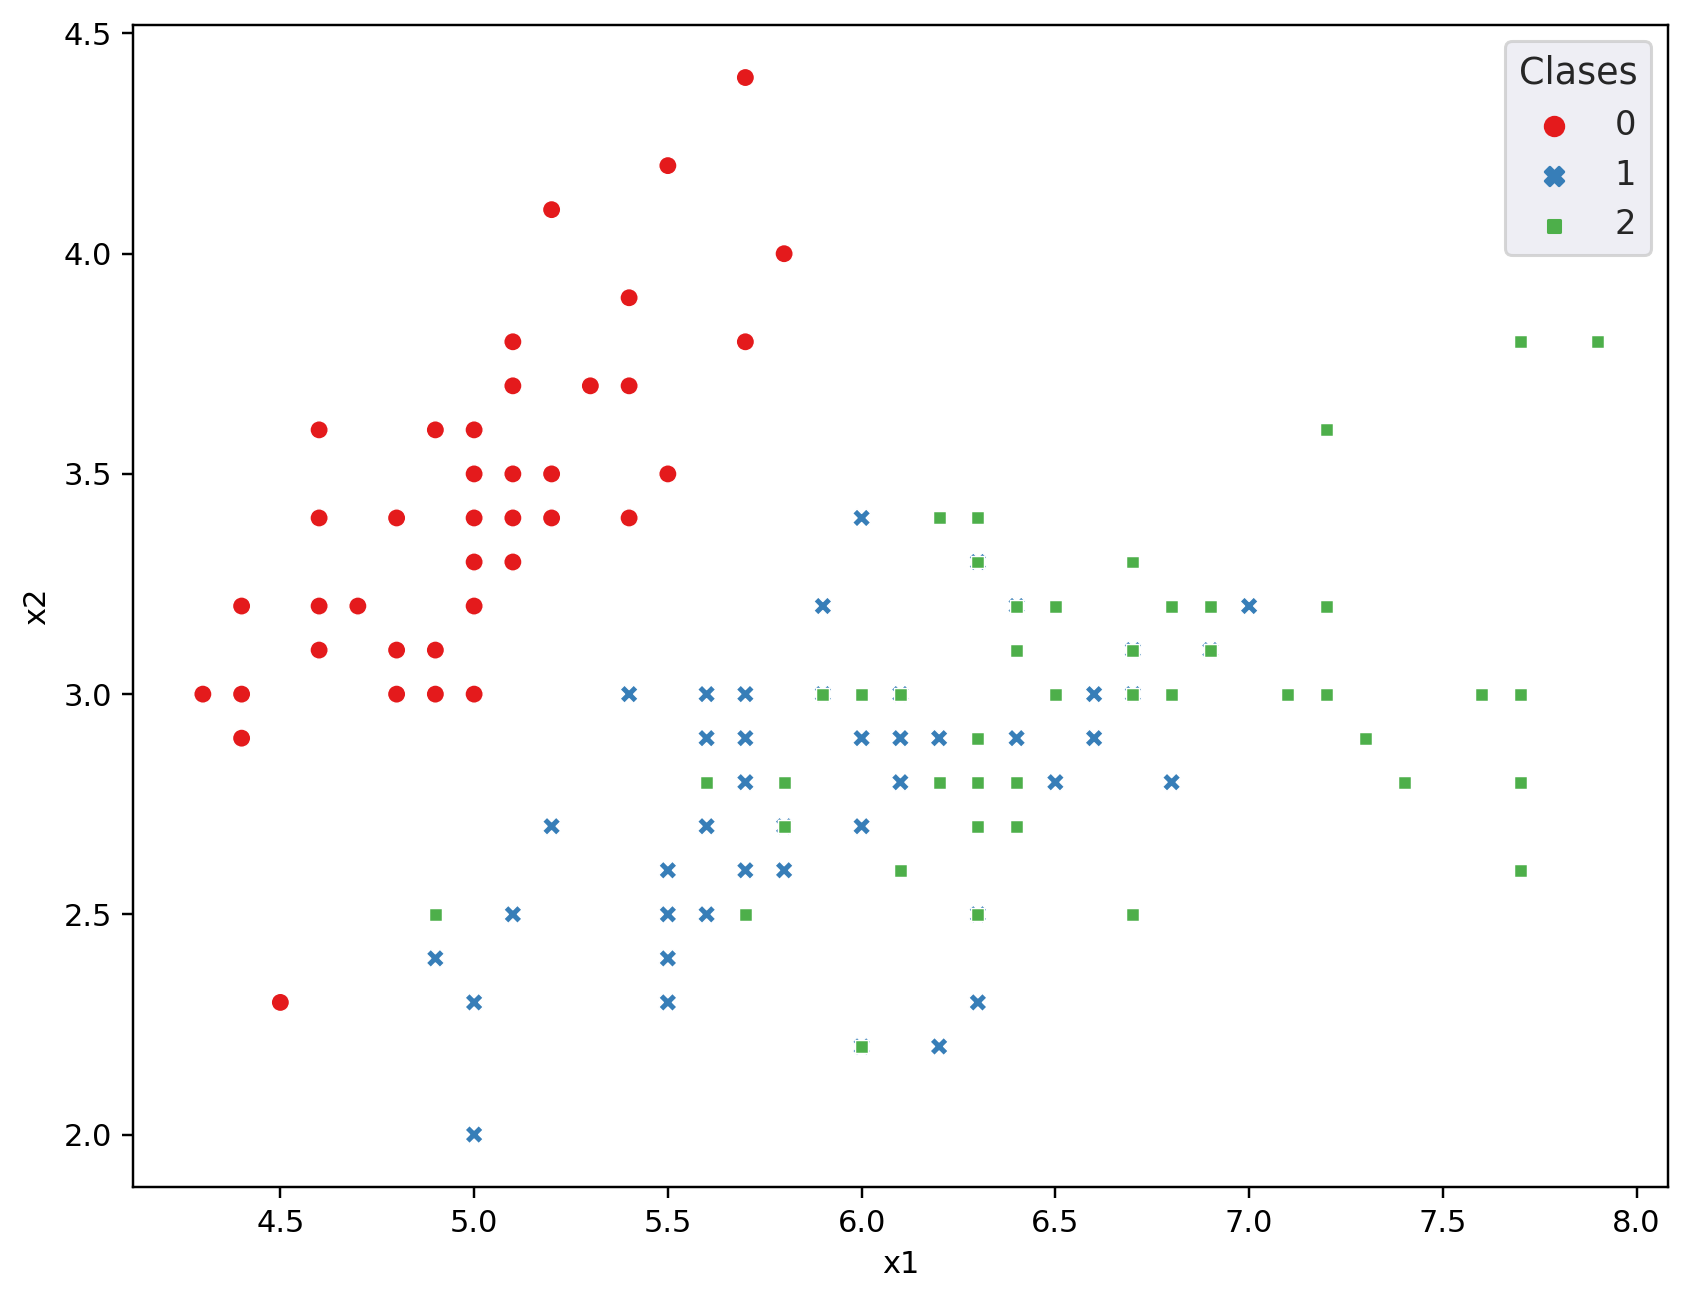

In [11]:
# Graficamos en un área 2d.
plot_data(X, y)

#### **2.2. Conjuntos de datos sintéticos**
---
Además de *Iris*, vamos a trabajar con dos conjuntos de datos artificiales. Estos son:

  * **`make_circles`**: Este conjunto de datos artificial genera dos variables que representan dos círculos, uno mayor y otro menor contenido en su interior. *Scikit-Learn* permite a su vez introducir algo de ruido sobre las muestras creadas.


In [12]:
# Conjunto de datos sintético circles.
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=600, 
                    noise=0.1, 
                    random_state=0)

In [13]:
# Información general del conjunto.

print(f'X ~ {X.shape[0]} muestras x {X.shape[1]} características.')
print(f'y ~ {y.shape[0]} muestras.')
print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:\n', y[:5])

X ~ 600 muestras x 2 características.
y ~ 600 muestras.

Primeras 5 muestras:
 [[-0.79959336  0.23505777]
 [-0.8693906   0.56906193]
 [ 0.03690973 -0.96481524]
 [-0.73333376 -0.60035   ]
 [-0.27028346 -0.98249038]]

Primeras 5 etiquetas:
 [1 0 0 1 0]


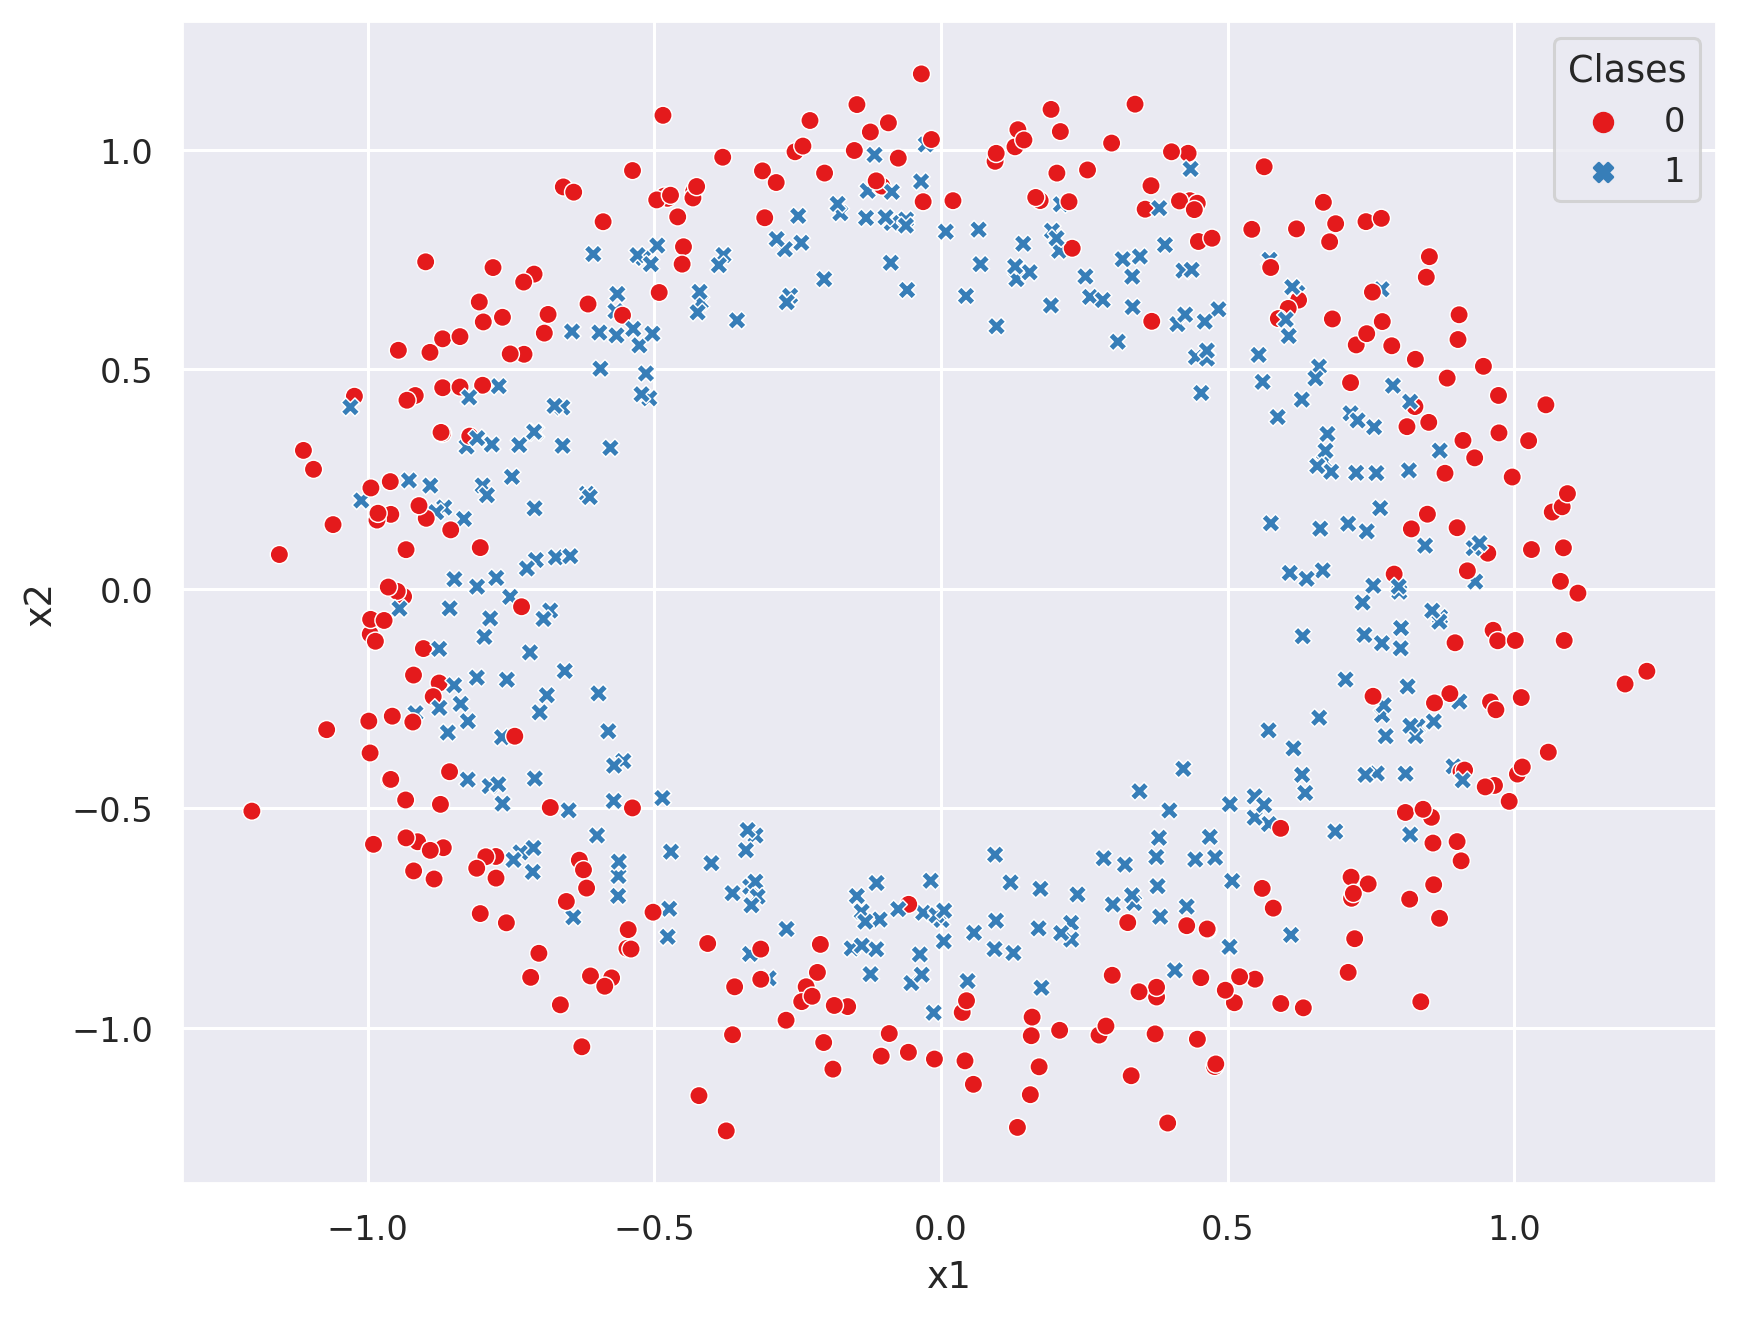

In [14]:
# Graficamos en un área 2d.
plot_data(X, y)

  * **`make_moons`**: Este conjunto de datos artificial genera dos variables asociadas a dos clases que representan dos medias lunas. *Scikit-Learn* permite a su vez introducir algo de ruido sobre las muestras creadas.


In [15]:
#Conjunto de datos sintético moons.
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=600, #Número de observaciones o muestras.
                  noise=0.15,     #Cantidad de ruido aleatorio introducido.
                  random_state=0 #Semilla aleatoria para garantizar la replicabilidad.
                  )

In [16]:
#Información general del conjunto.

print(f'X ~ {X.shape[0]} muestras x {X.shape[1]} características.')
print(f'y ~ {y.shape[0]} muestras.')
print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:\n', y[:5])

X ~ 600 muestras x 2 características.
y ~ 600 muestras.

Primeras 5 muestras:
 [[ 0.77172208 -0.52882117]
 [ 0.23023466  0.98205132]
 [-0.61846873  0.7614099 ]
 [ 1.19039559 -0.66801557]
 [-0.34596664  0.73132122]]

Primeras 5 etiquetas:
 [1 0 0 1 0]


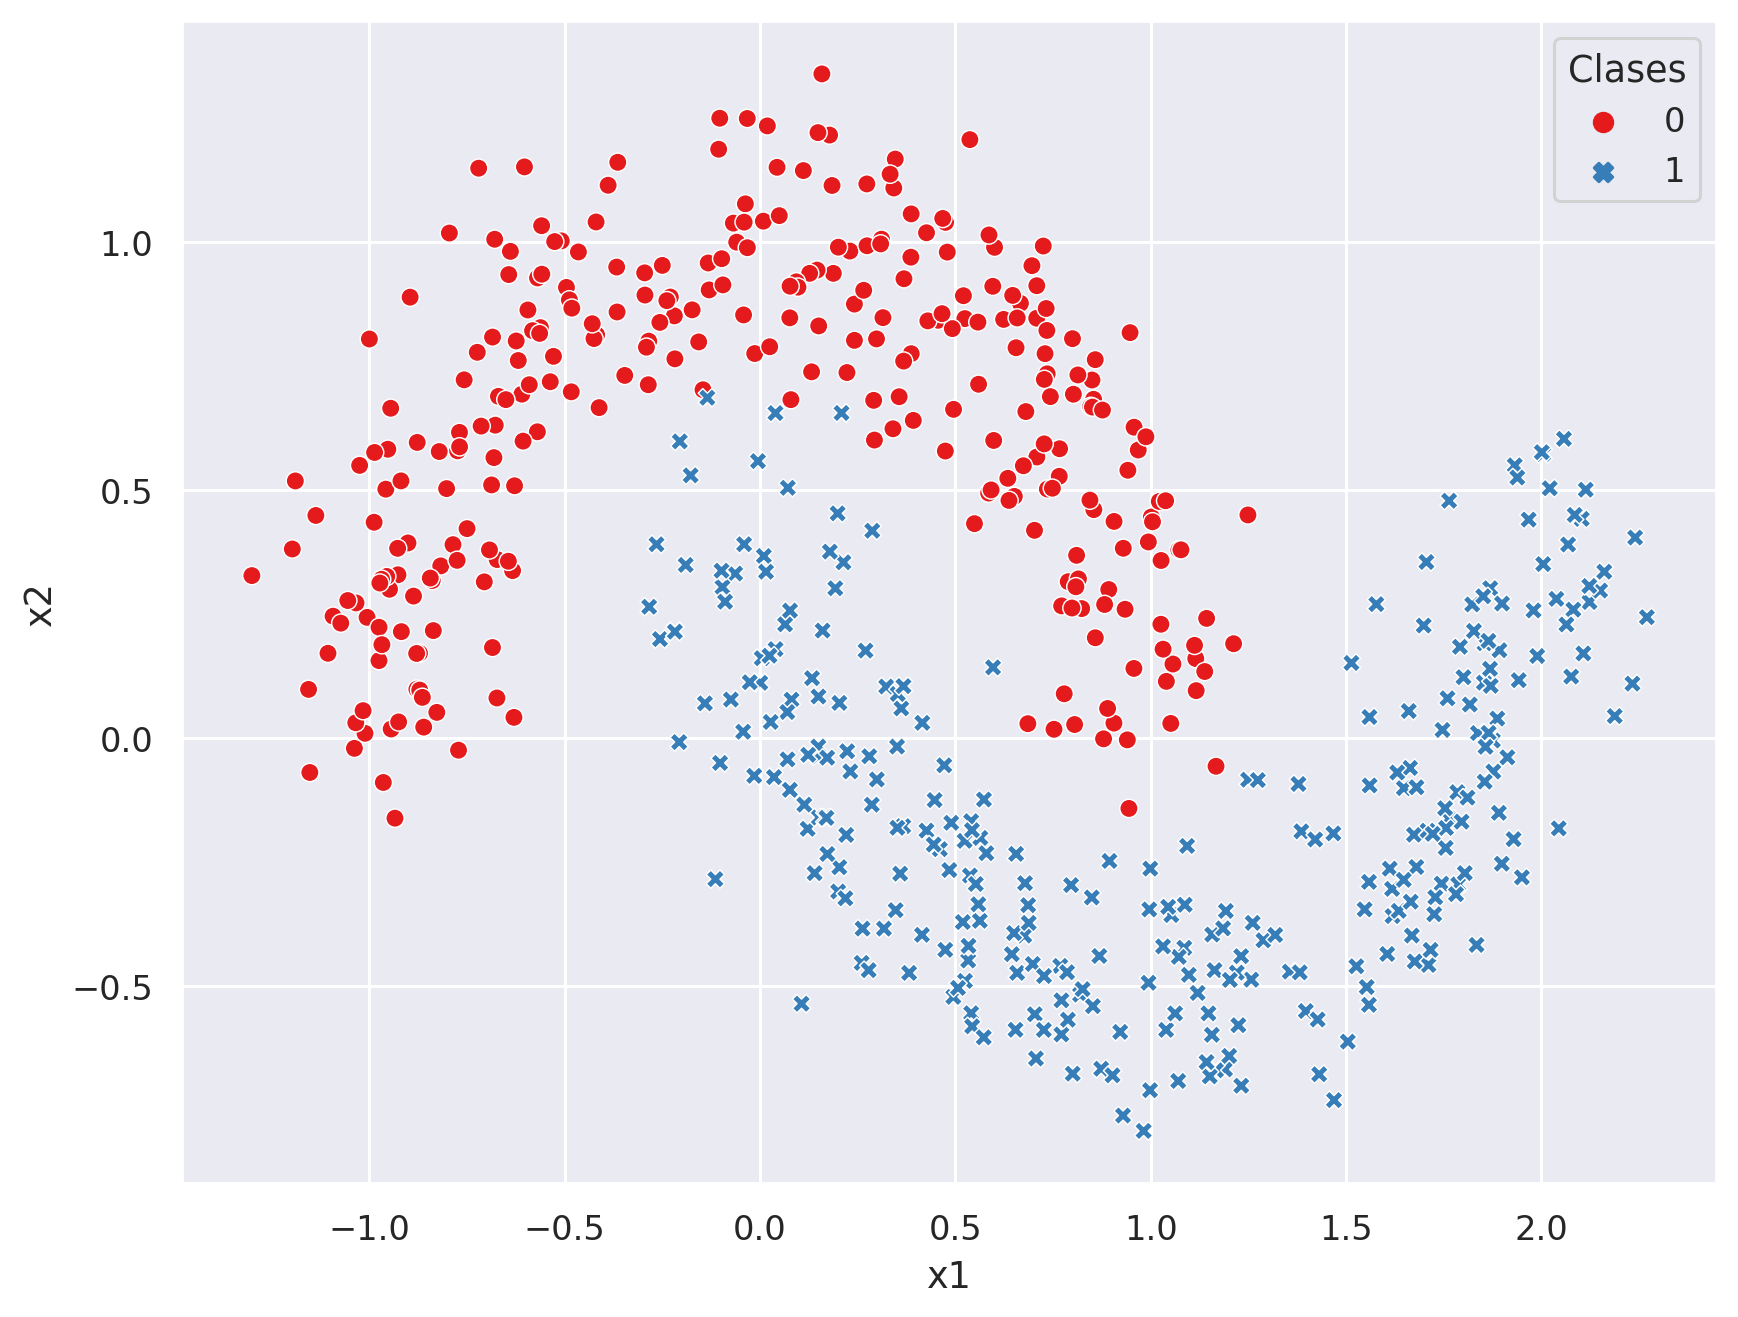

In [17]:
#Graficamos en un área 2d.
plot_data(X, y)

Estos conjuntos de datos producen un resultado interesante cuando se utilizan los métodos y modelos discutidos hasta ahora. Si aplicamos un modelo de **clasificación lineal** como una regresión logística, observamos que es difícil establecer una separación apropiada:

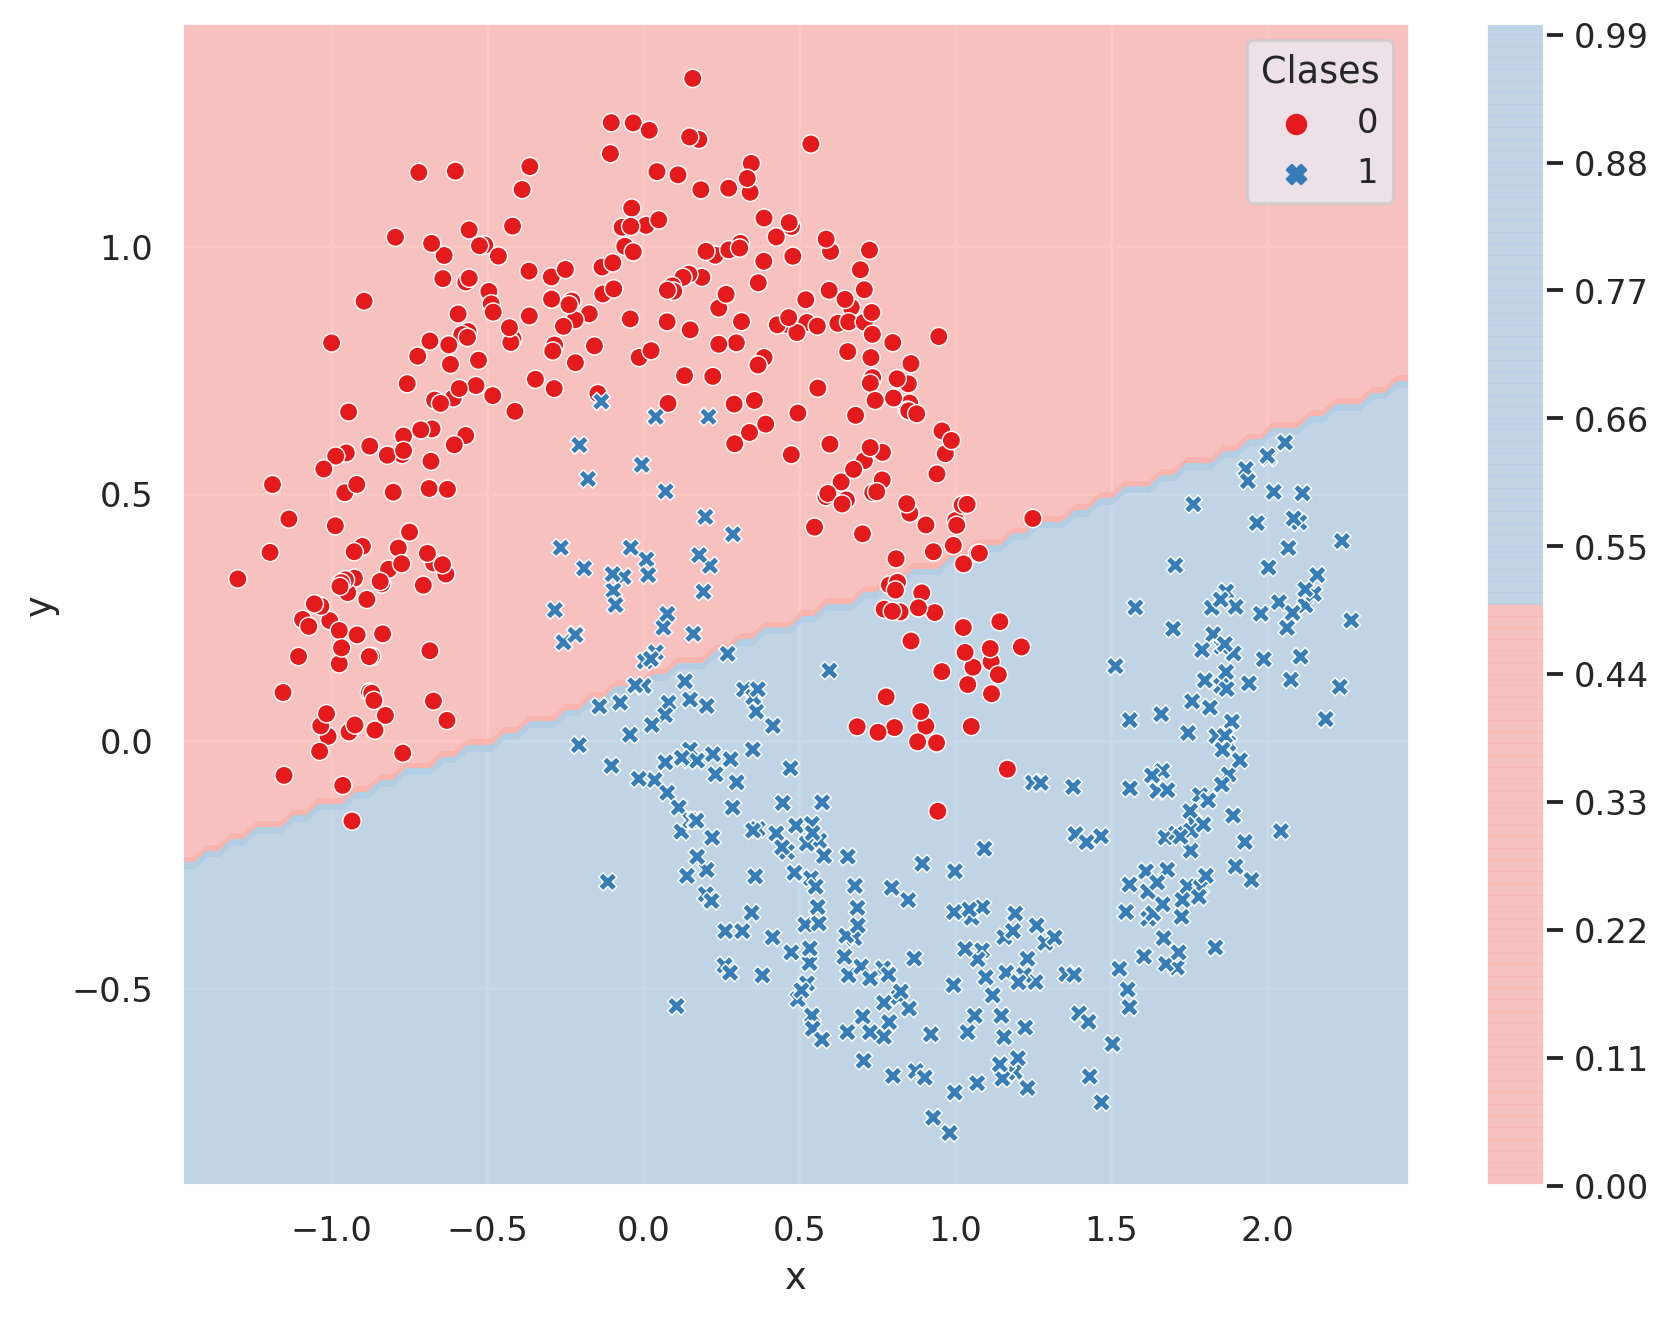

In [18]:
# Clasificador basado en regresión logística.
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs');
lr_model.fit(X, y)

plot_data(X, y, lr_model)

In [19]:
print("Score:", lr_model.score(X, y))

Score: 0.8883333333333333


Existen problemas en los que generar una clasificación lineal no produce un resultado apropiado, sin importar el tamaño del conjunto o tiempo invertido en el entrenamiento. Por lo tanto, surge la necesidad de usar un modelo que permita realizar una **clasificación no lineal**.

# **3. Árboles de Decisión**
---

El primer algoritmo de clasificación no lineal que discutiremos es el basado en **árboles de decisión**. Los árboles de decisión son muy intuitivos, pues codifican una serie de elecciones "**si esto**" y "**si no, entonces**", de forma muy similar a como una persona tomaría una decisión, o un programa simple usando las estructuras **`if`** y **`else`**. La gran ventaja de esta técnica es que estas elecciones se pueden aprender de forma automática a partir de los datos y existen maneras de identificar de manera automática las mejores condiciones y ramificaciones del árbol generado.

Por ejemplo, considere el siguiente árbol de decisión. Este árbol de decisión describe una serie de elecciones que buscan determinar si espero (**V**) o no (**F**) por una mesa en un restaurante.

<img src="https://drive.google.com/uc?export=view&id=1XrQiEx-PRqJDjSaoXvhh2a_YxxNlRUy0">


Con base al anterior árbol de decisión, puedo tomar la decisión de esperar o no, usando unas reglas de clasificación sencillas con preguntas como:
* ¿Cuántos clientes hay en el restaurante?
* ¿Cuánto tiempo tengo que esperar?
* ¿Tengo alguna alternativa de restaurante?
* ¿Tengo hambre en este momento?
* ¿Es viernes o sábado?
* ¿Tengo reservación?

Como puede apreciar, estos árboles pueden tener una interpretación muy intuitiva. Para tomar una decisión, o más bien realizar una clasificación de la situación, evaluaríamos esta condición en la observación sobre la que queremos tomar una decisión y avanzamos a la siguiente condición o estado final. Así, se realizarían preguntas como:

* **Si `Clientes == "Lleno"` Y `EsperaEstimada == "10-30"` Y `Hambre == "No"` Entonces `Esperar="SÍ"`**.
* **Si `Clientes == "Algunos"` Entonces `Esperar="SI"`**.
* **Si `Clientes == "Lleno"` Y `EsperaEstimada == ">60"` Entonces `Esperar="NO"`**.

In [20]:
#@markdown **Video: Ejemplo de predicción con árboles de decisión**
#@markdown ***

from IPython.display import HTML

HTML('<iframe style="width:768px; height: 432px;" src="https://drive.google.com/file/d/1vbCDEIBnrSbEfsIMtirHj8J-mOzSNCoP/preview"></iframe>')

## **3.1. Ventajas y desventajas**
---

**Ventajas**

* Los datos de entrada requieren muy poco preprocesamiento. Los árboles de decisión pueden trabajar con variables de diferente tipo (continuas y categóricas) y son invariantes al escalamiento de las características. 
* Los modelos son fáciles de interpretar y los árboles pueden ser visualizados.
* El costo computacional del uso del árbol para predecir la categoría de un ejemplo es mínimo comparado con otras técnicas (se realiza en tiempo logarítmico).

**Desventajas**

* Puede ser tan complejo, que se memoriza el conjunto de datos, por lo tanto, no generaliza tan bien (**sobreajuste**).
* Son muy sensibles al desbalance de clases (**sesgo**).

## **3.2. Implementación en *Scikit-Learn***
---

La implementación de *Scikit-Learn* se consigue con la clase **`DecisionTreeClassifier`** del módulo **`sklearn.tree`**:

In [21]:
# Importamos el constructor del clasificador por árboles de decisión.
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()

Cargamos de nuevo nuestros conjuntos de datos _Iris_ y _moons_.

In [22]:
#Conjunto de datos iris
iris = load_iris()

X_iris = iris.data[:,[0, 2]] # Usamos solo dos variables (longitud del sépalo y del pétalo)
y_iris = iris.target

In [23]:
#Conjunto de datos de medias lunas
X_moons, y_moons = make_moons(n_samples=600, # Número de observaciones o muestras.
                              noise=0.3,     # Cantidad de ruido aleatorio introducido.
                              random_state=0 # Semilla aleatoria para garantizar la replicabilidad.
                              )

Algunos de los parámetros más importantes del clasificador **`DecisionTreeClassifier`** son:
* **`max_depth`**: profundidad máxima del árbol.
* **`criterion`**: medida para determinar la calidad del particionamiento generado por un atributo. Soporta el coeficiente de *Gini* y entropía.
* **`min_samples_split`**: controla el número mínimo de muestras que debe haber en un nodo luego de una partición.
* **`min_samples_leaf`**: controla el número mínimo de muestras que debe haber en un nodo hoja.

In [24]:
classifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [25]:
# Entrenamos el modelo con el conjunto de datos moons.

moons_DT_classifier =  DecisionTreeClassifier()
moons_DT_classifier = moons_DT_classifier.fit(X_moons, y_moons)

Visualizamos la superficie de decisión del clasificador

In [26]:
plot_data(X_moons, y_moons, moons_DT_classifier)

In [27]:
score = moons_DT_classifier.score(X_moons, y_moons)
print(f'Score: {score}')
print(f'Error: {1 - score}')

Score: 1.0
Error: 0.0


Y ahora podemos realizar el mismo proceso con el *dataset* *Iris*.

In [28]:
#Entrenamos el modelo con el conjunto de datos moons

iris_DT_classifier =  DecisionTreeClassifier()
iris_DT_classifier.fit(X_iris, y_iris)

DecisionTreeClassifier()

Visualizamos la superficie de decisión del clasificador.

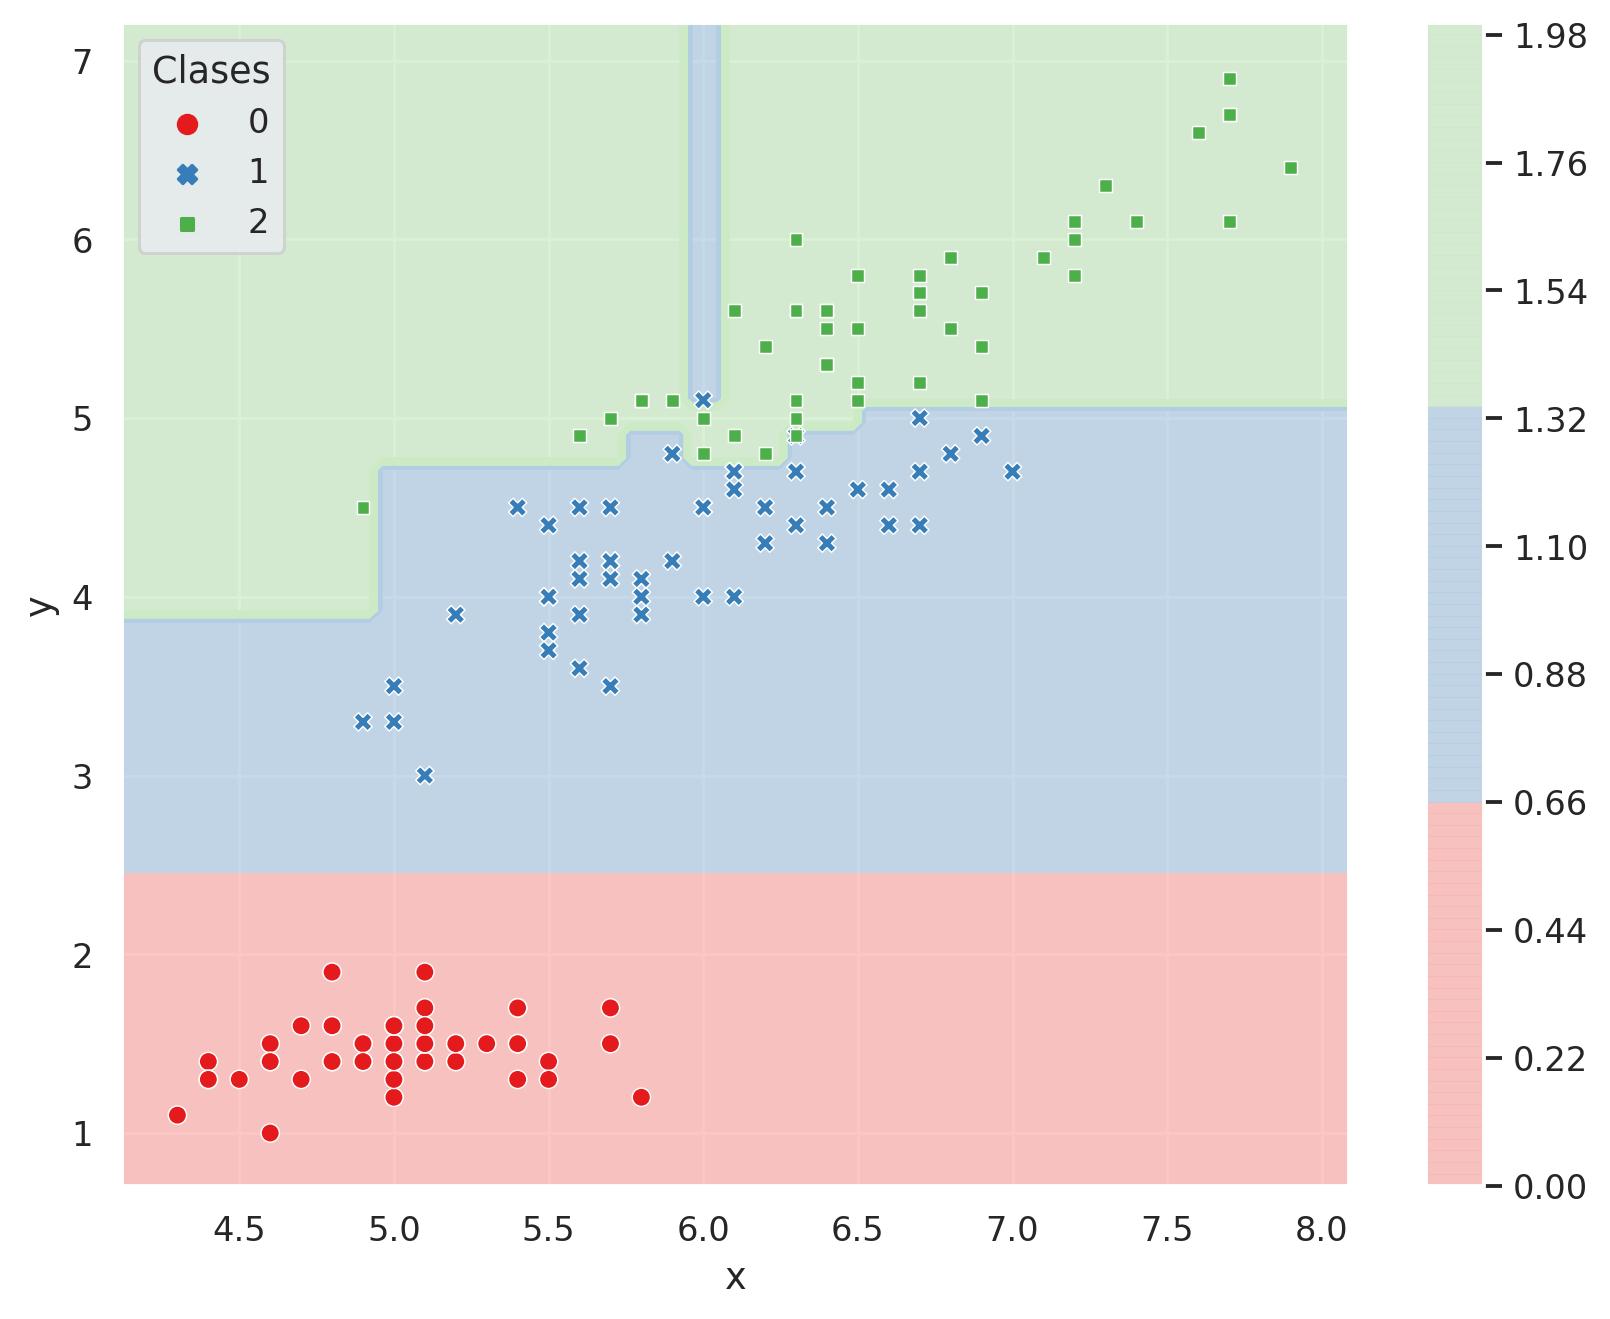

In [29]:
plot_data(X_iris, y_iris, iris_DT_classifier)

In [30]:
score = iris_DT_classifier.score(X_iris, y_iris)
print(f'Score: {score}')
print(f'Error: {1 - score}')

Score: 0.9933333333333333
Error: 0.00666666666666671


Ambos conjuntos de datos tienen un error con valor $0$, que apunta a un posible **sobreajuste**.

## **3.3. Visualización de árboles de decisión**
---

El árbol de decisión aprendido puede ser visualizado usando la librería de visualización de grafos **`graphviz`**. 

> **Nota:** En sistemas operativos basados en *Linux* como *Ubuntu* se recomienda instalarlo usando estas líneas:
  ```
  sudo apt-get install graphviz
  pip install graphviz
  pip install pydot
  ```

A continuación, vamos a usar el conjunto de datos *Iris* completo, usando las cuatro características, y su árbol de decisión, pero esta vez utilizaremos las 4 variables.

In [31]:
# Declaramos los datos de entrada.
X_iris = iris.data
y_iris = iris.target

# Declaramos y entrenamos el clasificador.
iris_DT_classifier = DecisionTreeClassifier(random_state=2)
iris_DT_classifier = iris_DT_classifier.fit(X_iris, y_iris)

Usamos **`graphviz`** para visualizar el árbol generado. El método **`graphviz`** soporta como parámetros los nombres de las clases y de las características a graficar. Además, con el método **`sklearn.tree.export_graphviz`** podemos generar la entrada de este método y así visualizar los modelos que entrenemos.

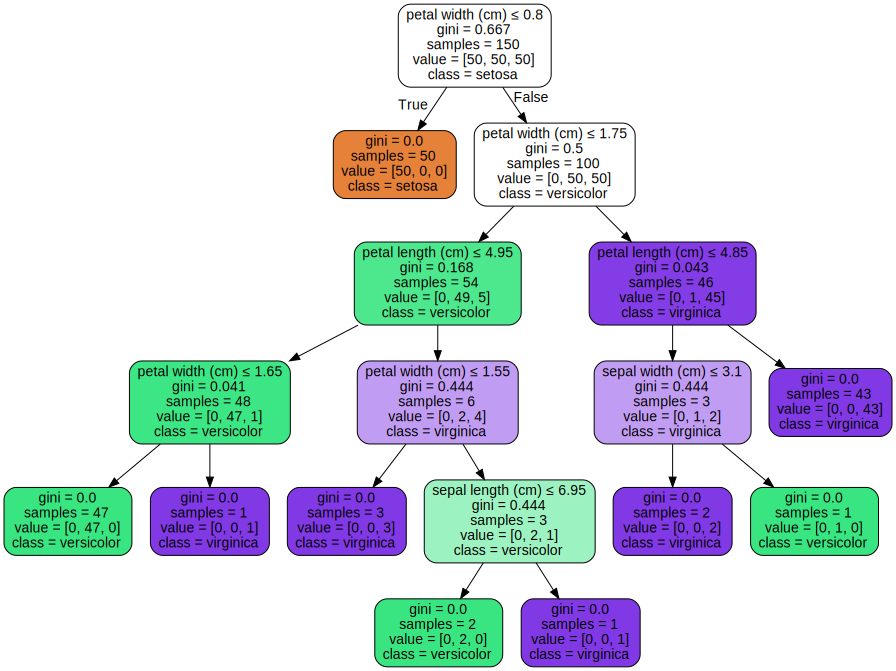

In [32]:
# Función de utilidad para la visualización de archivos SVG en notebooks.
from IPython.display import SVG

# Importamos la función de generación del archivo de descripción del árbol.
from sklearn.tree import export_graphviz

graphviz_data = export_graphviz(iris_DT_classifier, # Árbol de decisión entrenado.
                                out_file=None,      # Se usa 'None' para generar un string con el resultado.
                                feature_names=iris.feature_names,  # Nombre de las características.
                                class_names=iris.target_names,     # Nombre de las clases.
                                 # Configuración de estilo.
                                filled=True, rounded=True, special_characters=True)  

# Generamos el grafo de graphviz para la visualización.
graph = graphviz.Source(graphviz_data)

# Exportamos en formato svg y visualizamos con IPython.
SVG(graph.pipe(format='svg'))

Podemos ver cómo resultó el modelo construido y las reglas que se definieron en la construcción del árbol. Una cosa a tener en cuenta es la diferenciación inmediata de las flores de la clase **`setosa`** (en naranja) con la primera regla del árbol, en la que para todas las flores cuyo grosor de pétalo es menor que $0.8 (cm)$ se clasifican en esta especie. 

Tras esto, nos podemos imaginar que el grosor de pétalo es especialmente importante para distinguir las flores *setosa*. ¿Hay alguna forma de identificar la importancia de cada variable?

## **3.4. Importancia de las variables**
---

Una de las ventajas de usar árboles de decisión, es que nos permite determinar la importancia de cada característica, con base al índice de impureza usado. *Scikit-Learn* nos permite acceder a la importancia de cada característica llamando el atributo **`feature_importances_`** del clasificador. Esta importancia cuantifica qué tanto aporta cada característica a mejorar el desempeño del árbol.

In [33]:
# Valores entre 0 y 1 del aporte al desempeño de cada característica.
iris_DT_classifier.feature_importances_

array([0.01333333, 0.01333333, 0.05072262, 0.92261071])

El atributo **`feature_importances_`** contiene un arreglo de *Numpy* del tamaño igual al número de características. Por ejemplo, la importancia de la característica $0$ (**`sepal length (cm)`**) es de $1.3\%$.

In [34]:
# Nombres de las características a partir del bunch.
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Entonces, podríamos decir que, para el modelo construido, las variables aportan a la decisión de la siguiente forma:


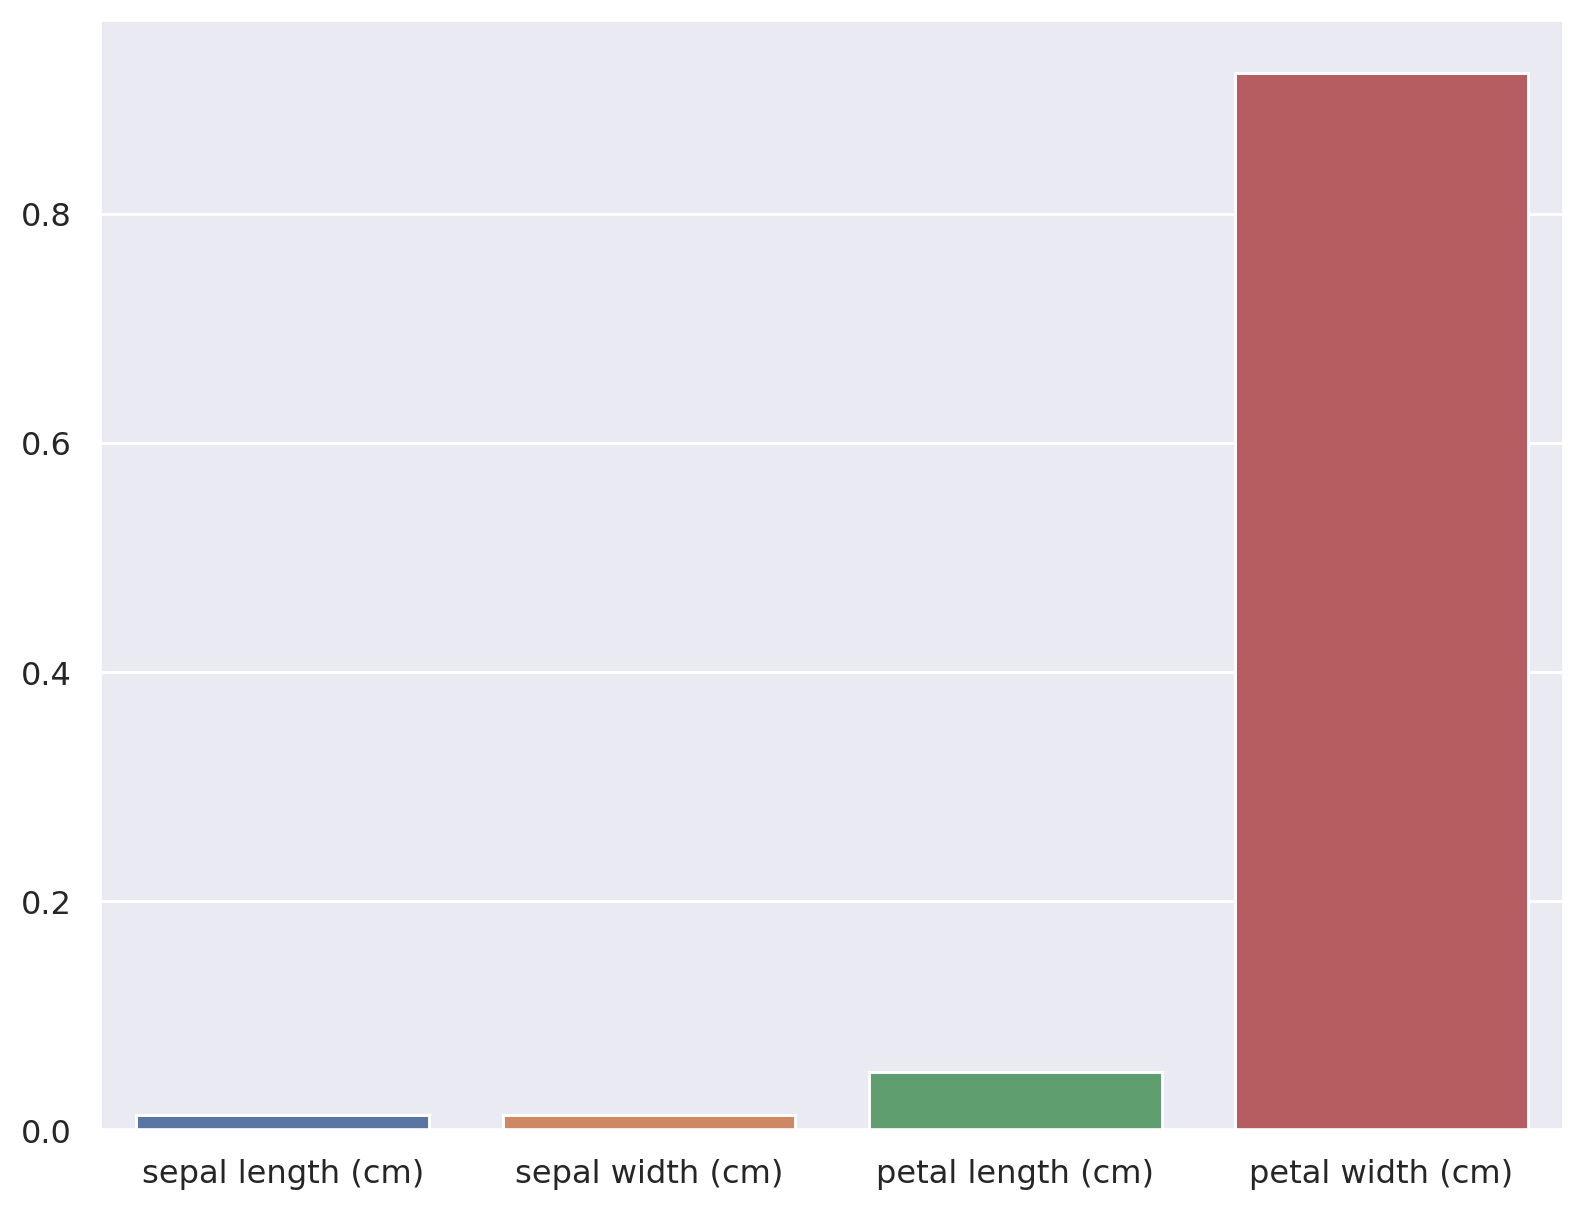

In [35]:
sns.barplot(x = iris.feature_names,  # Nombre de las características.
            y = iris_DT_classifier.feature_importances_ ); # Importancia de cada característica.

## **3.5. Evaluación de la complejidad usando `DecisionTreeClassifier`**
---

Para evaluar la complejidad, vamos a estimar este valor tomando como referencia la profundidad del árbol.

In [36]:
# Función de partición en subconjuntos de entrenamiento y pruebas.
from sklearn.model_selection import train_test_split   

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, 
                                                    test_size=0.3,     # Proporción de datos usados para el grupo de evaluación.
                                                    random_state=1234, # Semilla aleatoria para la replicabilidad.
                                                    stratify=y_iris)   # Estratificar con respecto a la etiqueta.

Vamos a explorar los siguientes valores de profundidad máxima:
* $[1, 2, 3, \dots, 20]$

In [37]:
# Números enteros de 1 a 20 como posibles valores del hiperparámetro de profundidad.
max_depth_values = np.arange(1, 21)

# Arreglos vacíos para almacenar el error de entrenamiento y el de generalización.
train_error = np.empty(len(max_depth_values))
generalization_error = np.empty(len(max_depth_values))


for depth in max_depth_values:
    # Entrenamos un árbol de decisión para cada valor de profundidad.
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)

    # Almacenamos el error de entrenamiento y de generalización por cada árbol.
    train_error[depth - 1] = (1 - decision_tree.score(X_train, y_train))
    generalization_error[depth - 1] = (1 - decision_tree.score(X_test, y_test))

Visualizamos la curva de error de entrenamiento contra error de generalización:

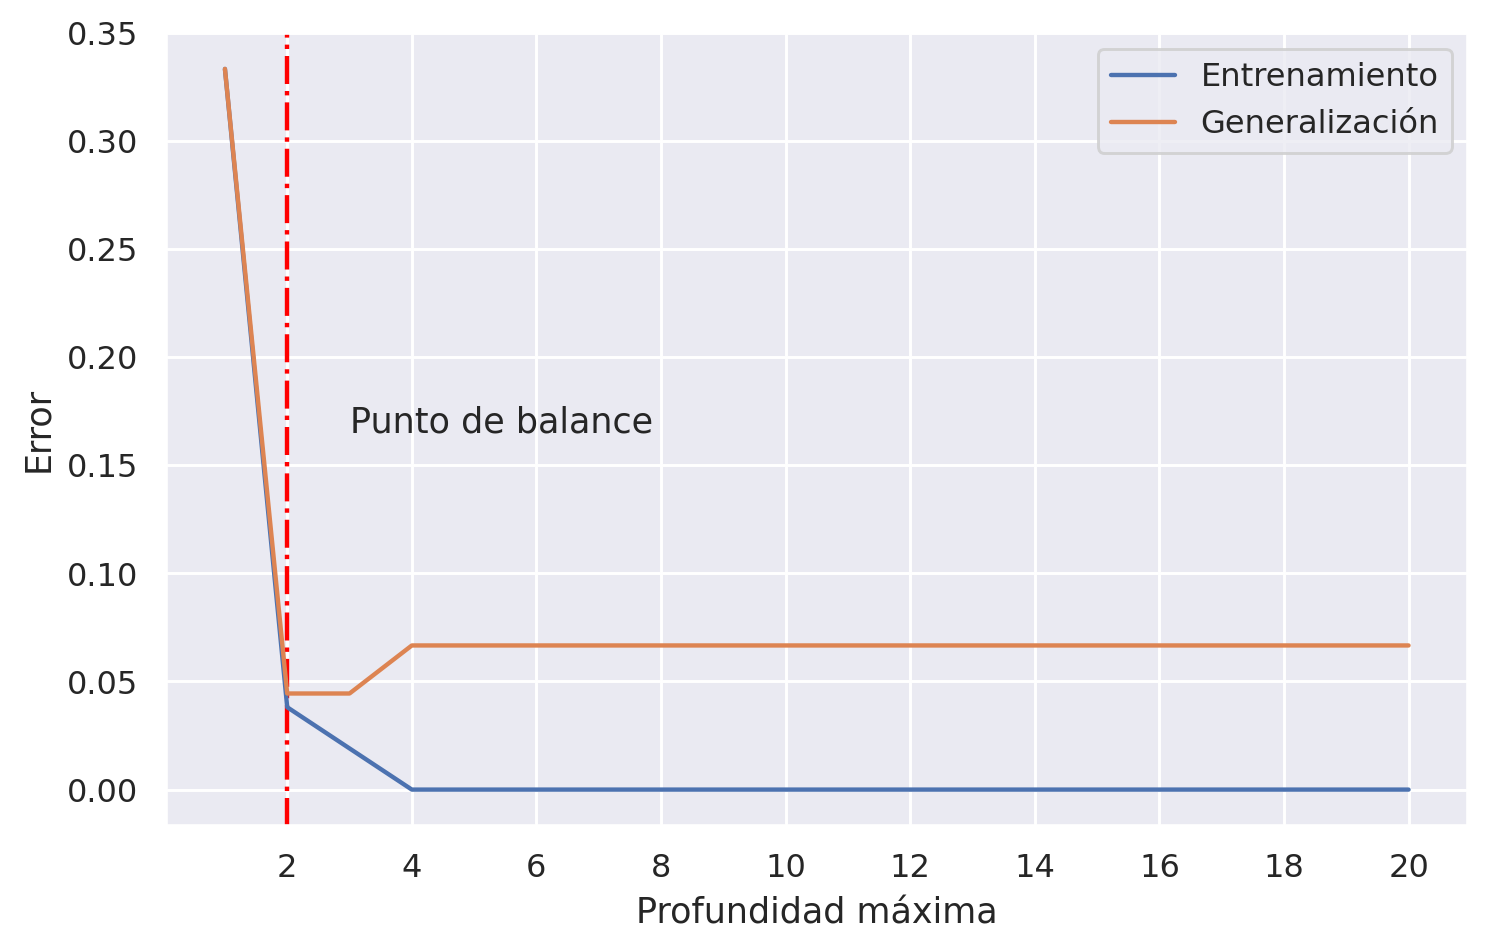

In [38]:
plot_learning_curve(train_error, generalization_error)

En este caso, el balance entre ambos errores se alcanza muy rápido, con profundidad de $2$ nodos.

# **4. Máquinas de vectores de soporte (*SVM*)**
---
Las máquinas de vectores de soporte son un modelo de aprendizaje supervisado en el cual se busca representar a los ejemplos en un nuevo espacio, de tal forma que aquellos ejemplos de diferentes categorías sea posible, en principio, separarlos linealmente en este nuevo espacio. Considere el siguiente ejemplo, usando el conjunto de datos generados con el *Generator* **`make_circles`**.

In [39]:
X, y = make_circles(n_samples=1000, factor=.3, noise=.08 , random_state= 0)

Se trata de un conjunto de datos que no es linealmente separable

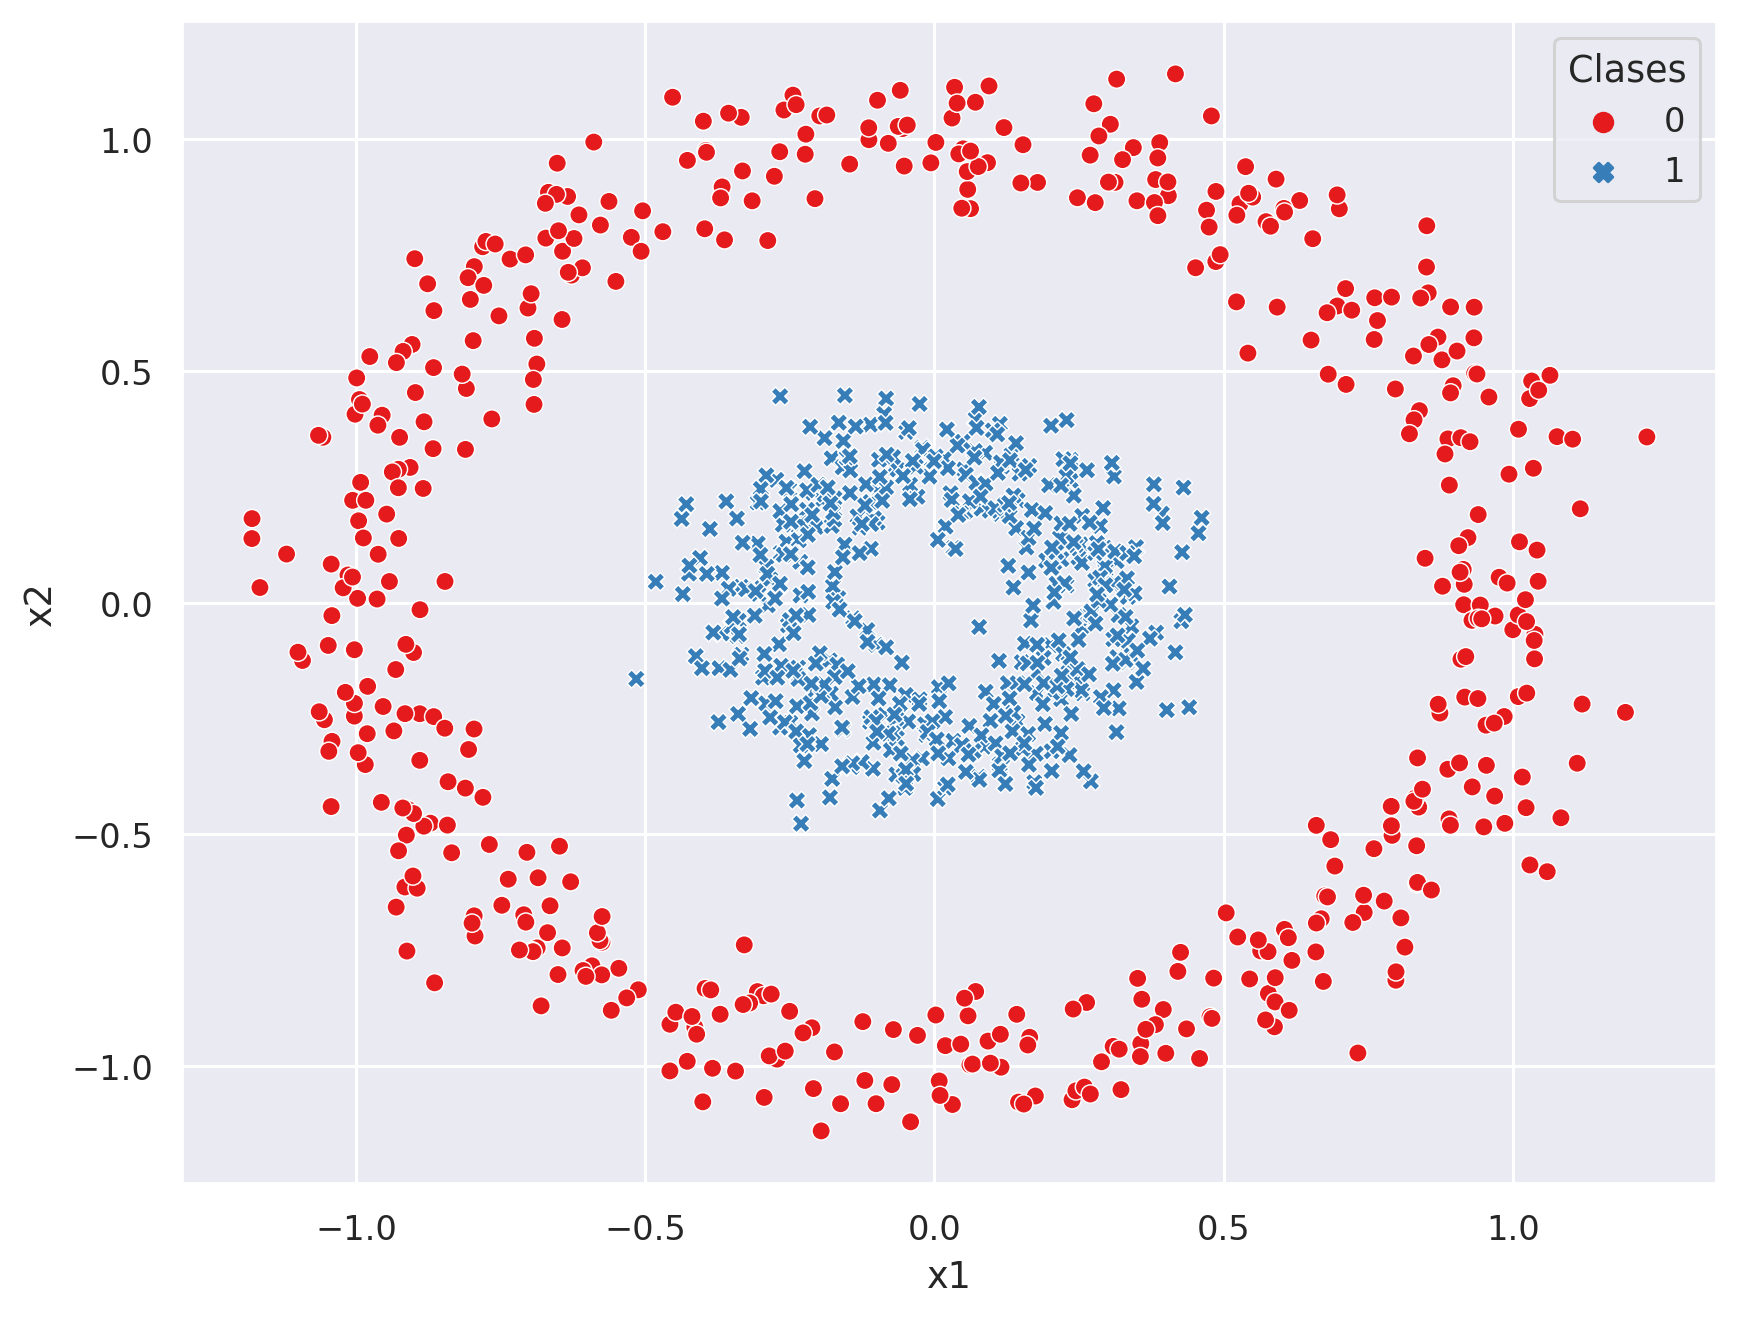

In [40]:
plot_data(X, y)

> **¿Se pueden separar las clases con una función lineal?** 

Si intentamos utilizar un modelo de clasificación lineal, podemos notar que el resultado no es apropiado. De hecho, este es un ejemplo de problema en el que es **imposible** distinguir directamente los datos con un clasificador lineal.

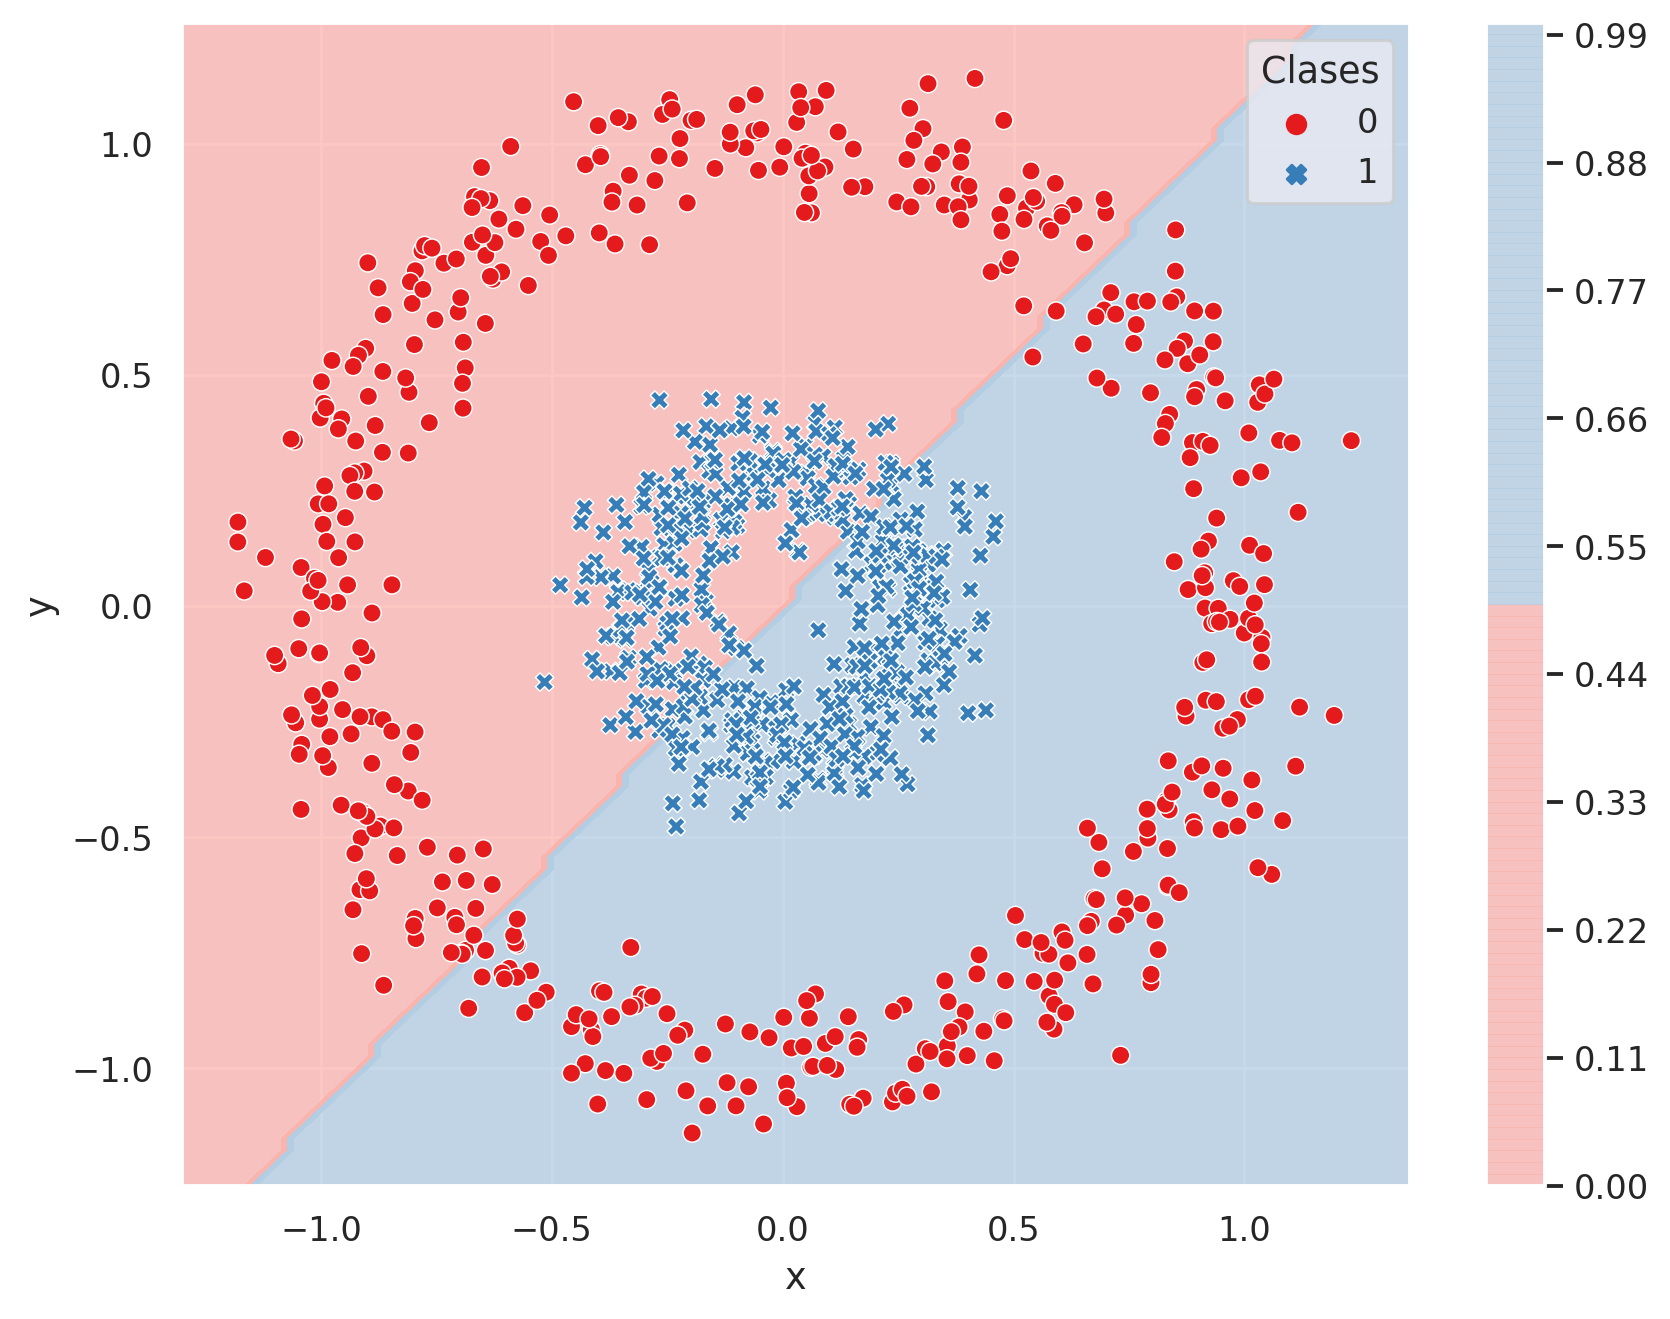

In [41]:
from sklearn.linear_model import LogisticRegression

# Declaramos y entrenamos un modelo de regresión logística.
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs');
lr_model.fit(X, y)

# Graficamos la región de decisión.
plot_data(X, y, lr_model)

In [42]:
# Imprimimos el score del modelo.
print("Score:", lr_model.score(X, y))

Score: 0.502


Un modelo *SVM* crea, implícitamente, un espacio de representación de mayor dimensionalidad en el cual sí podemos separar de forma clara nuestros datos. Esto se ilustra en la siguiente figura:

<img src="https://drive.google.com/uc?export=view&id=1NuYvzWfEb_nOZ9pWbsycdQWiHhad5_BI">

Para el ejemplo de los dos círculos, podemos llevar los datos a un nuevo espacio más apropiado. Para esto, usaremos un espacio donde las características corresponden al cuadrado de las características originales:

$$\begin{equation}
\begin{split}
\phi:& \mathbb{R}  & \longrightarrow & \mathbb{R}^2 \\
  & (x,y) & \longmapsto & (x^2,y^2)
\end{split}
\end{equation}$$

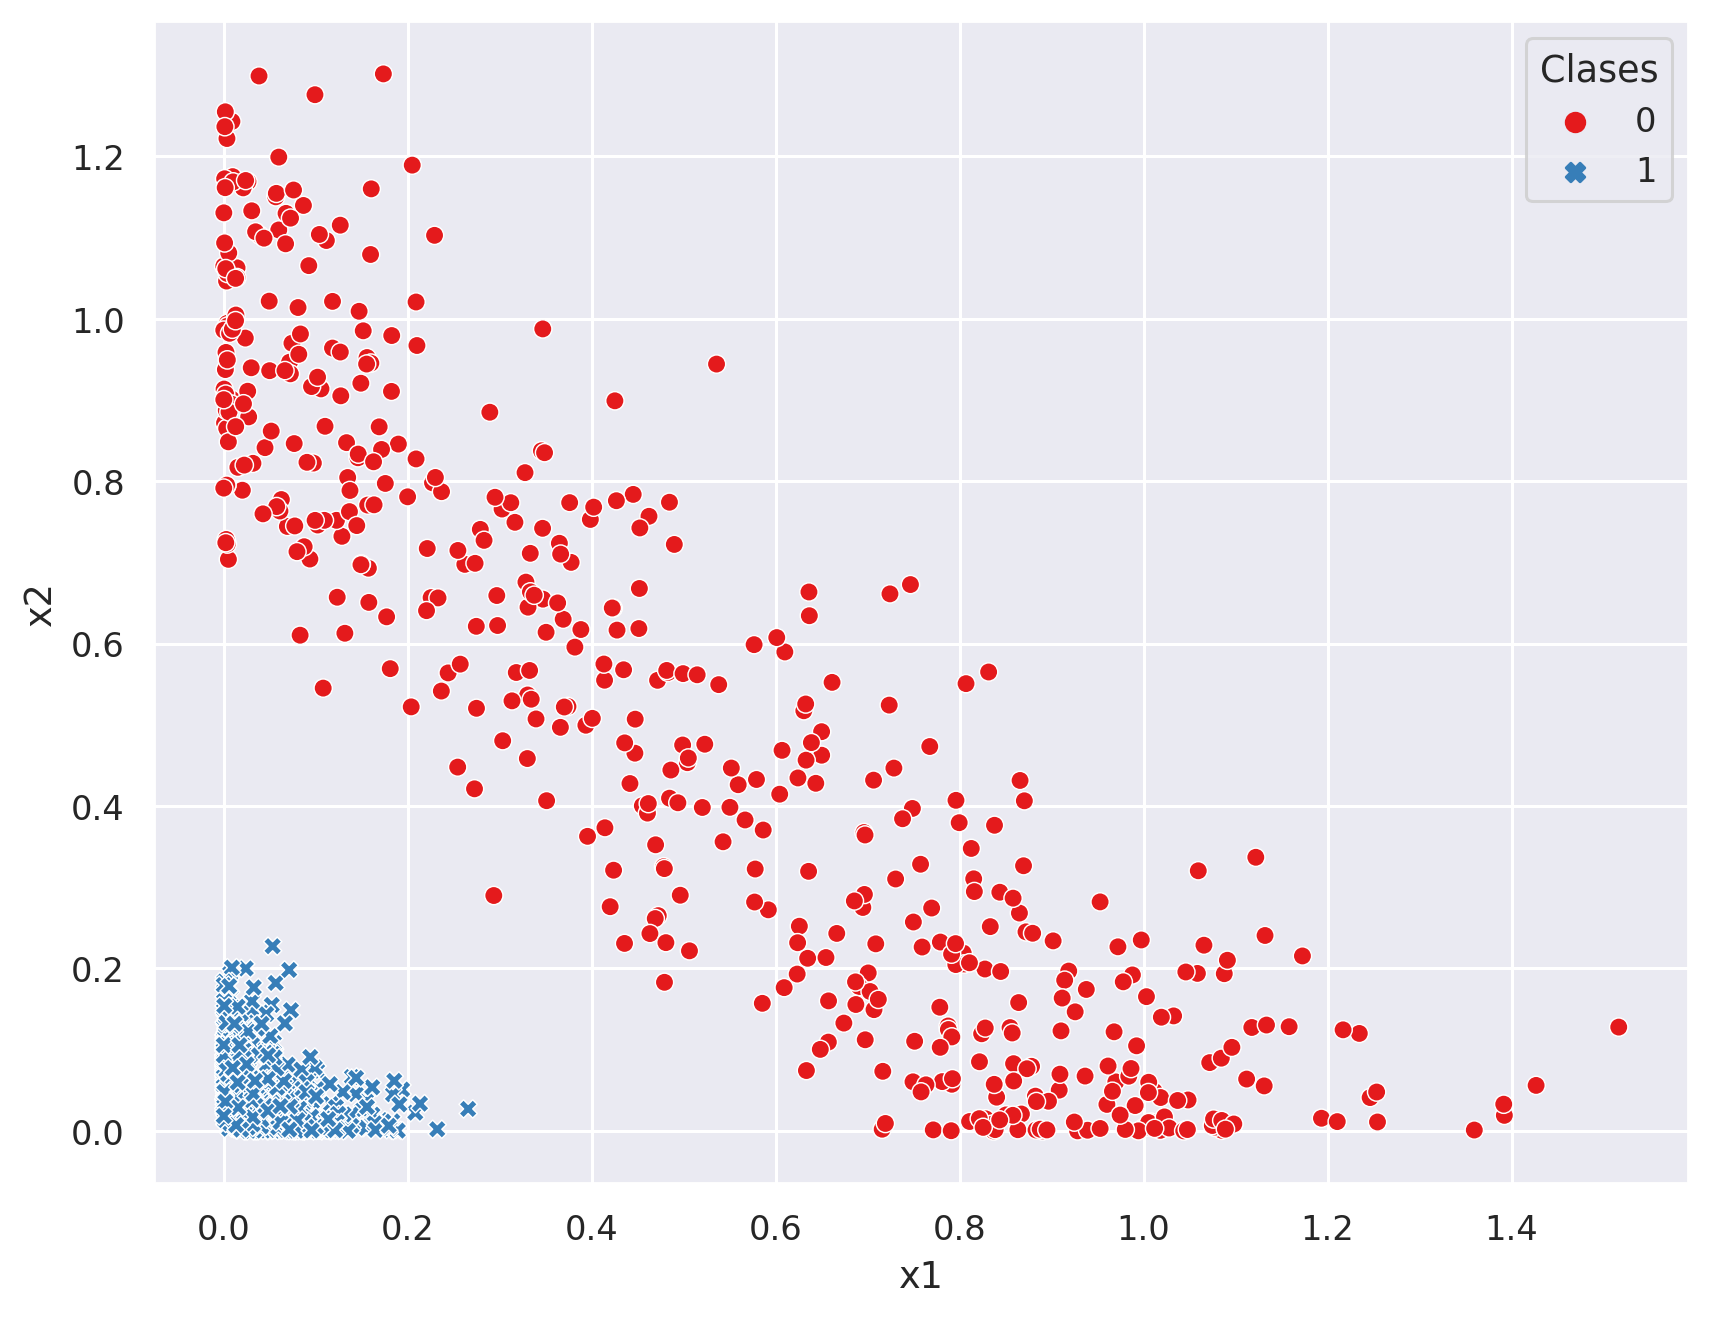

In [43]:
X_square = X * X

plot_data(X_square, y)

En este nuevo espacio de representación **SÍ** es posible separar los datos con un discriminante lineal.

### **4.1. Kernel trick**
---

SVM usa una función conocida como *Kernel*. Intuitivamente, esta función $k$ define qué tan parecidas son dos instancias del conjunto de datos. Formalmente, la función $k$ calcula el producto punto en el espacio de características donde se representarán los datos. Dependiendo del *kernel*, este espacio de características es de mayor dimensionalidad, y facilita la definición de un "*hiperplano*" que separe los ejemplos de ambas características. La dimensión de este *hiperplano* varía de acuerdo al número de características. Si se tienen 2, el *hiperplano* es una recta. Si se tienen 3 el *hiperplano* es un plano en un espacio de 3 dimensiones.

Existen varias opciones para las funciones de *kernel*. Primero, vamos a cargar nuevamente los dos conjuntos de datos (*iris* y *moons*) sobre los cuales vamos a comparar la superficie de decisión generada por cada tipo de *kernel*. Empezaremos de una vez con la división en grupos de entrenamiento y evaluación. 

In [44]:
# Dataset de flores iris
iris = load_iris()

X_iris = iris.data[:,[0, 2]] 
y_iris = iris.target
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, 
                                                                        y_iris, 
                                                                        test_size=0.3, 
                                                                        random_state=1)

In [45]:
# Dataset sintético de lunas
X_moons, y_moons = make_moons(n_samples=600, noise=0.3, random_state=0)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, 
                                                                            y_moons, 
                                                                            test_size=0.3, 
                                                                            random_state=1)

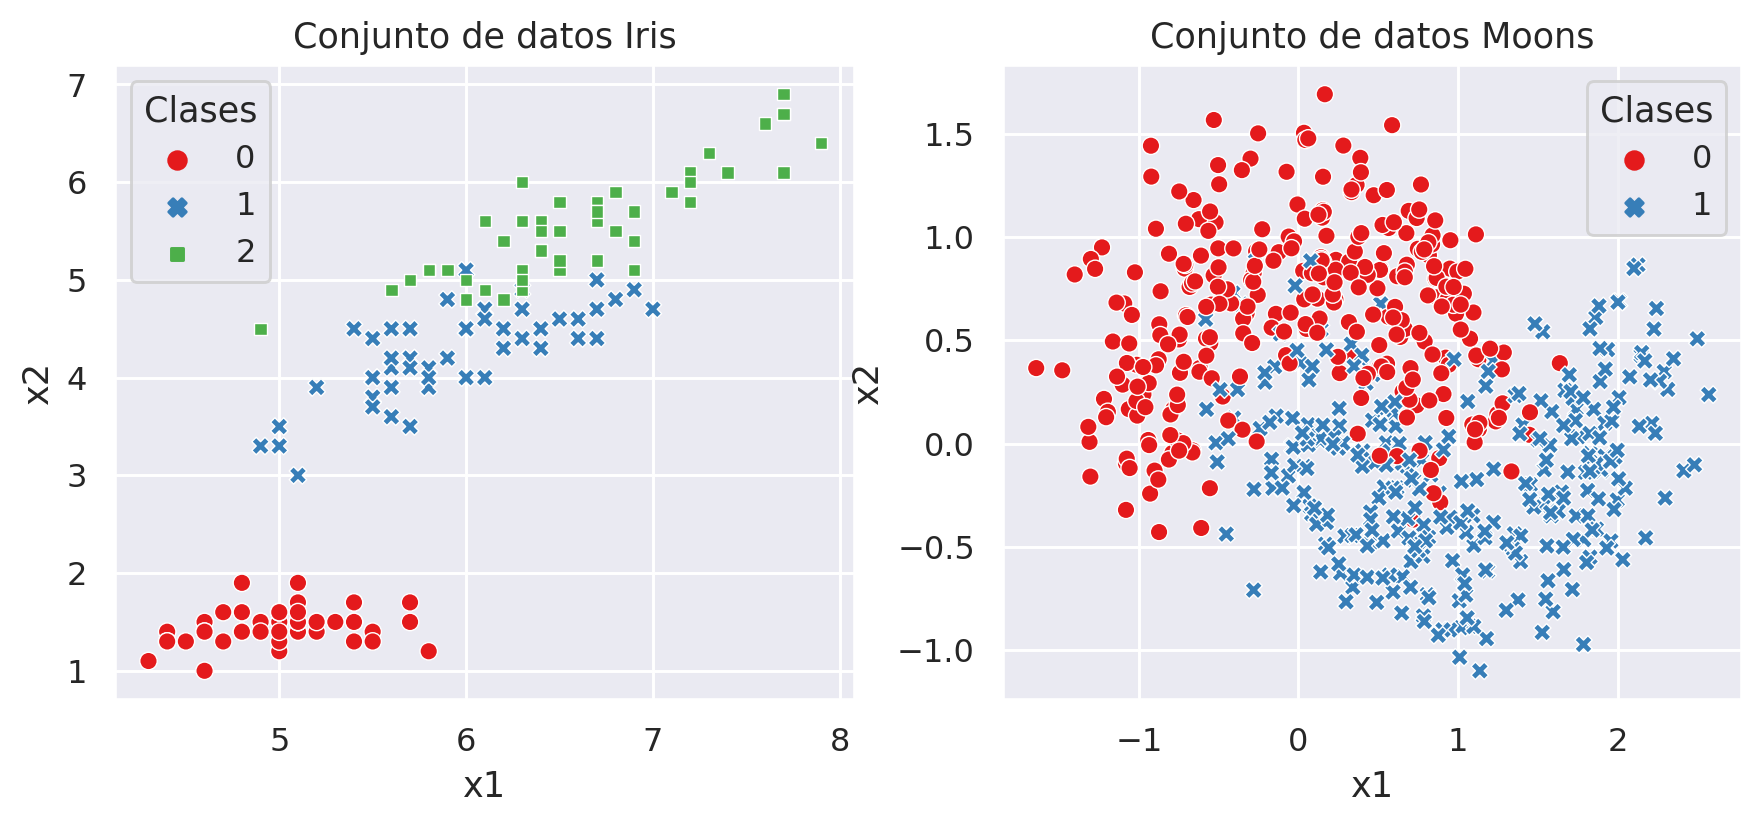

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
plot_data(X_iris, y_iris, ax = ax1, title = 'Conjunto de datos Iris')
plot_data(X_moons, y_moons, ax = ax2, title = 'Conjunto de datos Moons')

#### **4.1.1. Kernel Lineal**
---

En un *kernel* lineal, la función $k$ está definida como:
$$
k(x,y) = \langle x, y\rangle = xy^T
$$

Esta implementación puede ser consultada a través de **`sklearn.svm.LinearSVC`**.

In [47]:
# Modelo de máquina de vector de soporte con kernel lineal.
from sklearn.svm import LinearSVC

# Declaramos el modelo SVC lineal para ambos conjuntos de datos.
linear_iris = LinearSVC(max_iter=5000)
linear_moons = LinearSVC(max_iter=5000)

# Entrenamos cada modelo con sus datos de entrada respectivos.
linear_iris.fit(X_train_iris, y_train_iris)
linear_moons.fit(X_train_moons, y_train_moons);

Ahora visualizamos los datos de ambos:

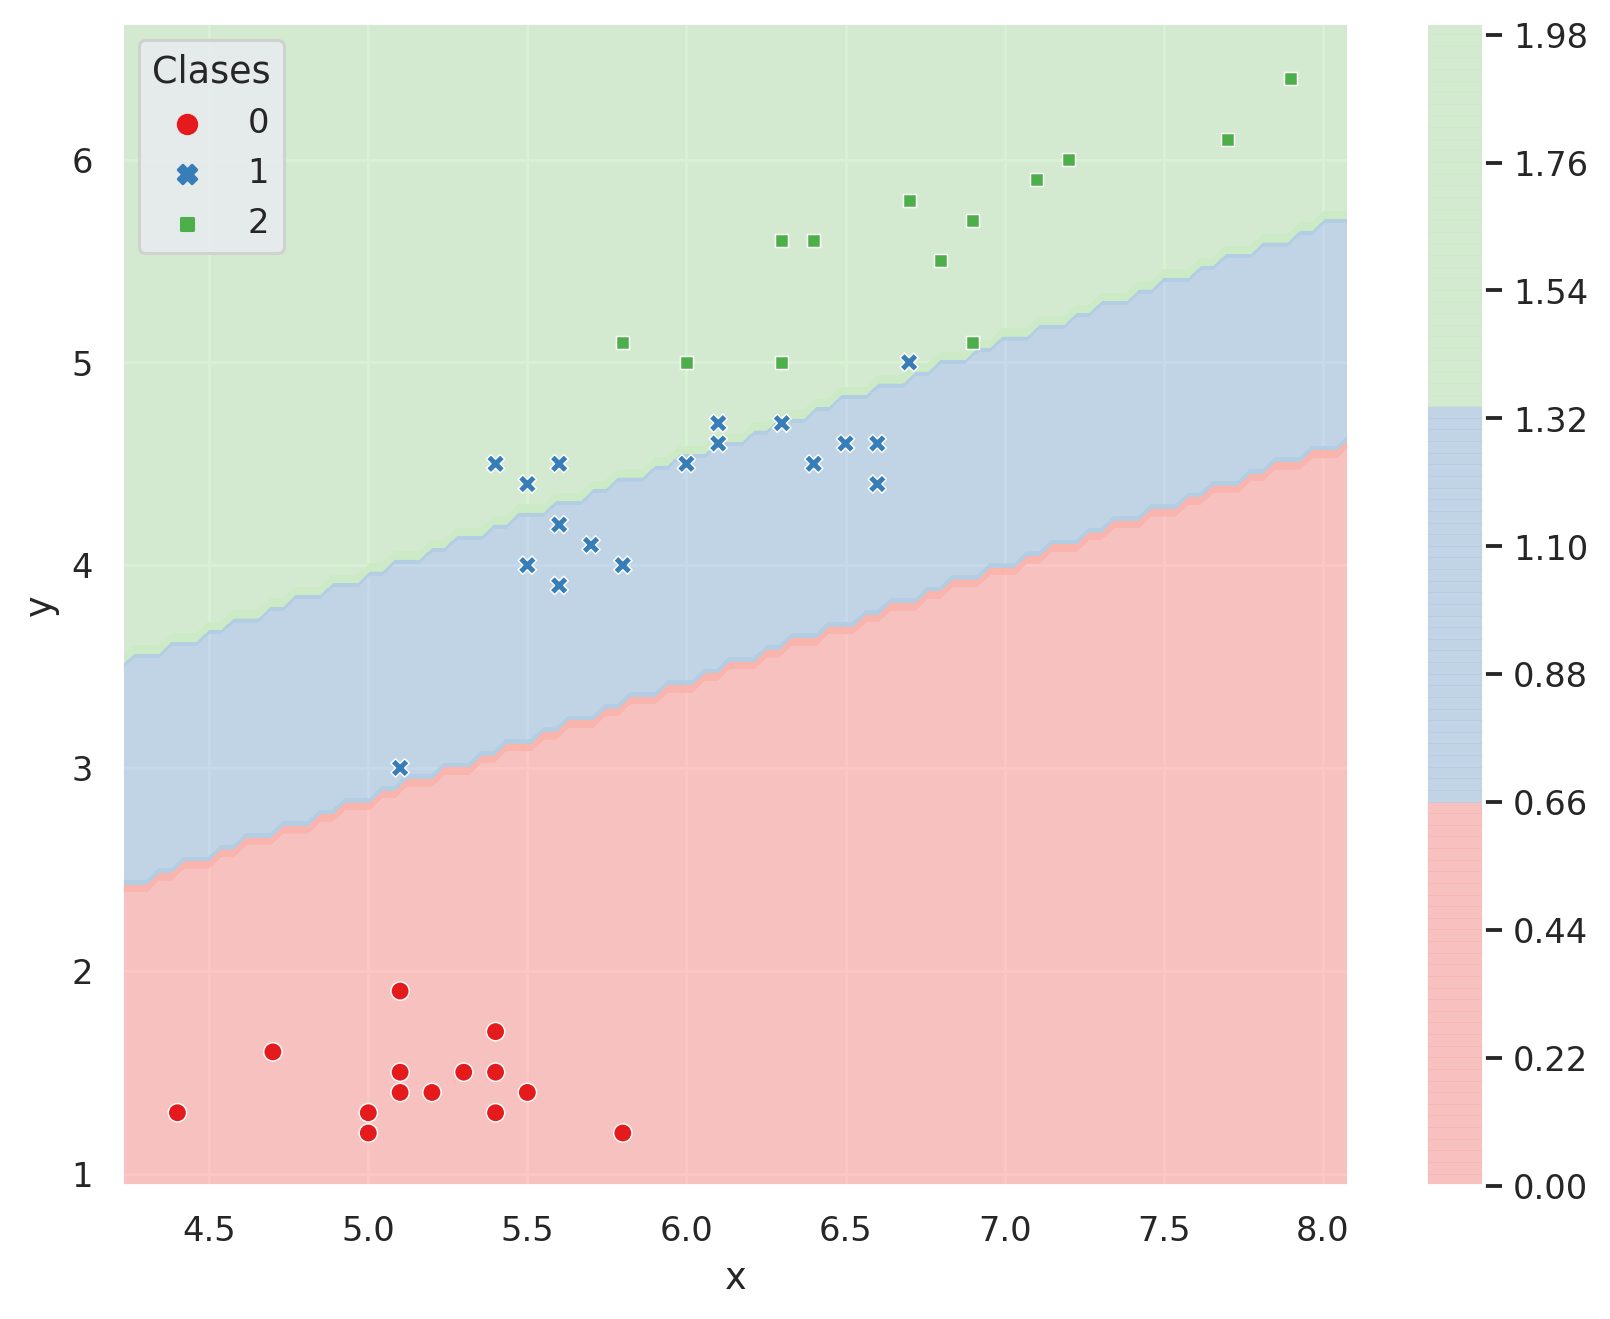

In [48]:
plot_data(X_test_iris, y_test_iris, linear_iris)

El error en el conjunto de entrenamiento y prueba es el siguiente:

In [49]:
print(f"Error en entrenamiento:\t{1-linear_iris.score(X_train_iris, y_train_iris):.4f}")
print(f"Error en prueba:\t{1-linear_iris.score(X_test_iris, y_test_iris):.4f}")

Error en entrenamiento:	0.0476
Error en prueba:	0.1111


Ahora hacemos lo mismo para el conjunto de datos generado artificialmente:

In [51]:
#plot_data(X_moons, y_moons, linear_moons)
plot_data(X_test_moons, y_test_moons, linear_moons)

In [53]:
print(f"Error en entrenamiento:\t{1-linear_moons.score(X_train_moons, y_train_moons):.4f}")
print(f"Error en prueba:\t{1-linear_moons.score(X_test_moons, y_test_moons):.4f}")

Error en entrenamiento:	0.1238
Error en prueba:	0.1500


Hasta el momento, los resultados son muy similares a los que obtendríamos con otro método de clasificación lineal.

#### **4.1.2. Kernel Gaussiano**
---

Otro kernel muy importante es el **_kernel_ gaussiano**. Este está definido por la siguiente función:
$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
la cual se puede simplificar como
$$
K(x, x') = \exp(-\gamma \|x-x'\|^2)
$$
$$
\gamma \ = \frac{1}{2\sigma^2}
$$
En la literatura, este método también se encuentra como *kernel* usando una función de base radial (**RBF** por del ingles *Radial basis function*).

Para implementar un clasificador de vectores de soporte con un *kernel* gaussiano podemos utilizar el constructor de clasificadores basados en máquinas de soporte general **`sklearn.SVC`**. Esta es una versión general de este tipo de clasificador, que acepta distintos argumentos para definir el método deseado. 

En el siguiente ejemplo probamos con un valor pequeño del argumento $\gamma$ (**`gamma`**):

In [54]:
#Clasificador de vectores de soporte general.
from sklearn.svm import SVC        

rbf_svm = SVC(kernel='rbf',   # Kernel de tipo RBF
              gamma = 0.001)  # Valor del argumento gamma

rbf_svm.fit(X_train_moons, y_train_moons);

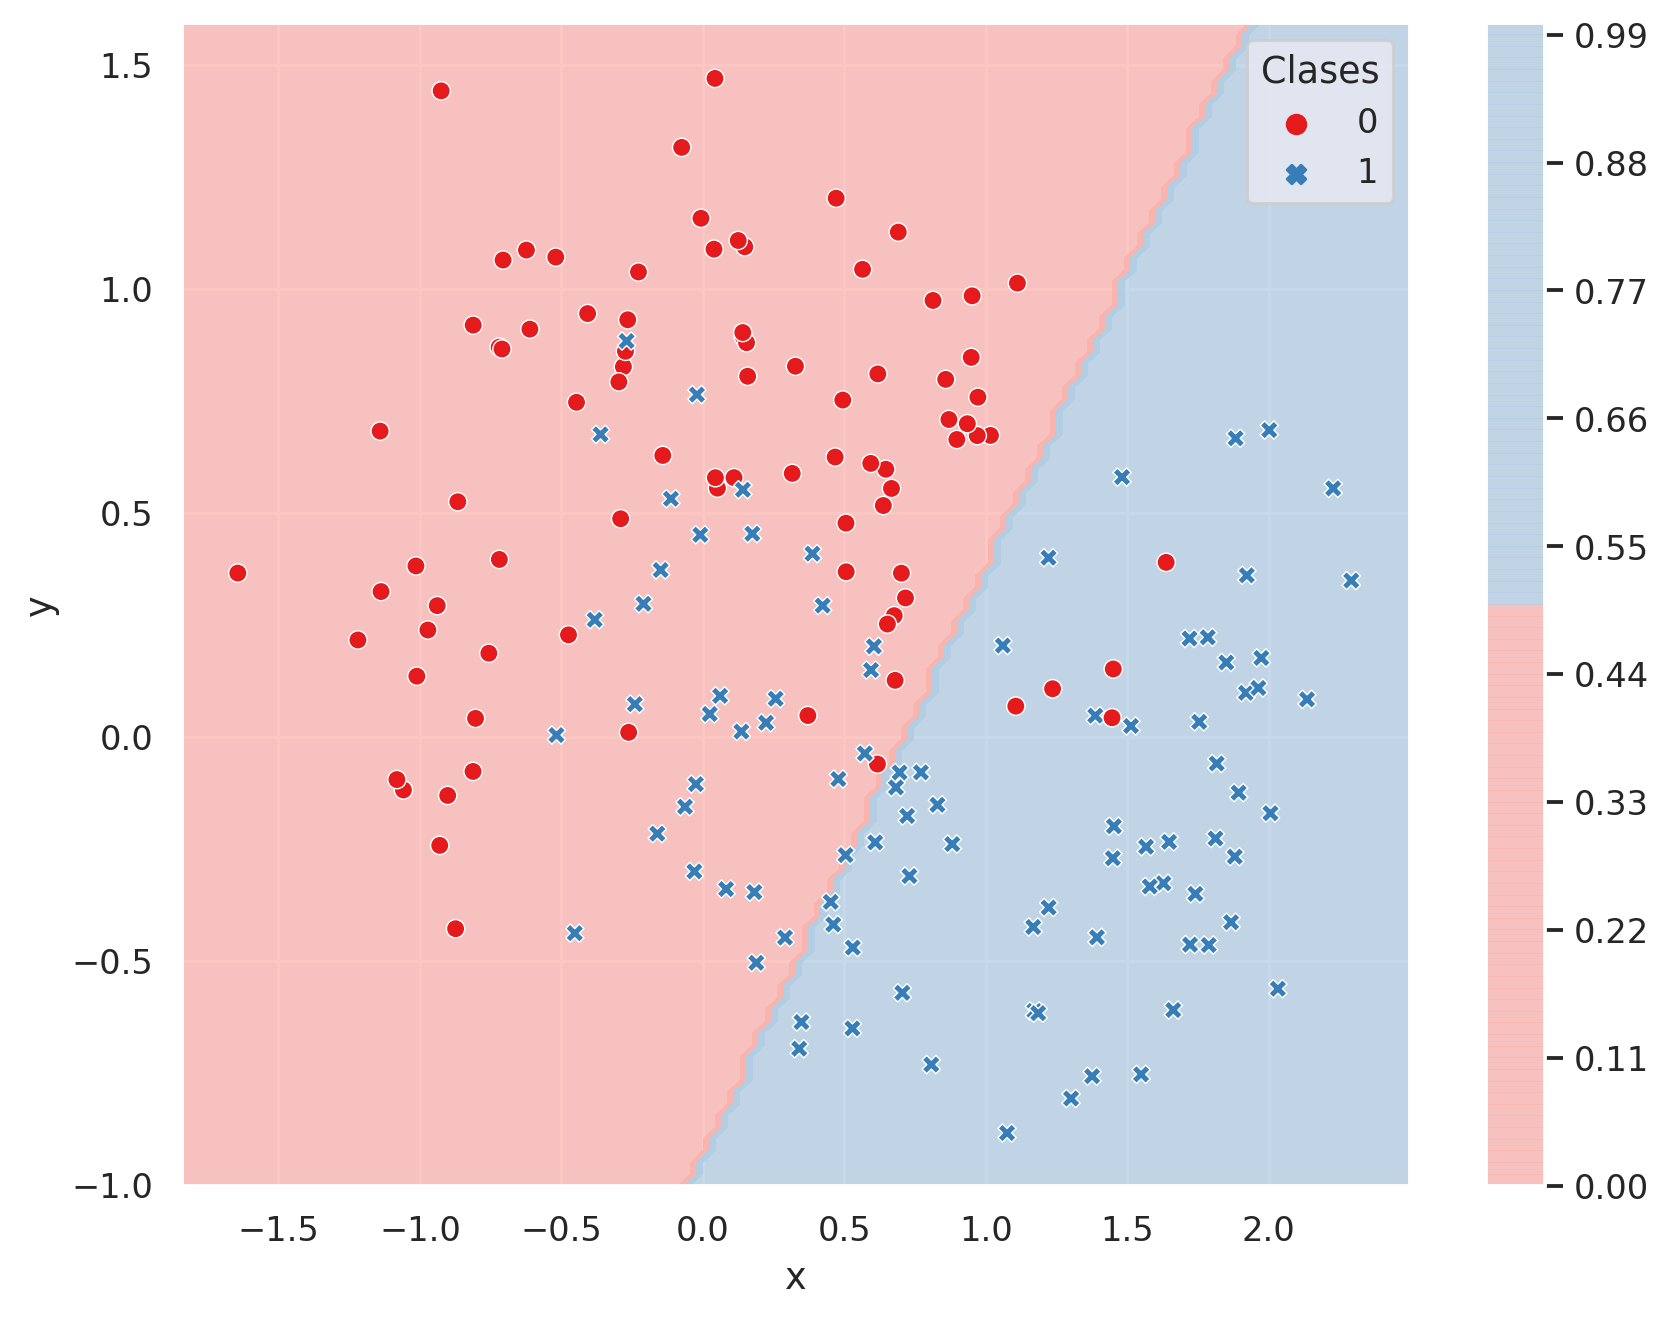

In [55]:
plot_data(X_test_moons, y_test_moons, rbf_svm)

Reportamos el error de entrenamiento y prueba:

In [56]:
print(f"Error en entrenamiento:\t {1-rbf_svm.score(X_train_moons, y_train_moons):.4f}")
print(f"Error en prueba:\t {1-rbf_svm.score(X_test_moons, y_test_moons):.4f}")

Error en entrenamiento:	 0.2000
Error en prueba:	 0.2111


El resultado no es mucho mejor al obtenido previamente. Usemos ahora un $\gamma$ más grande.

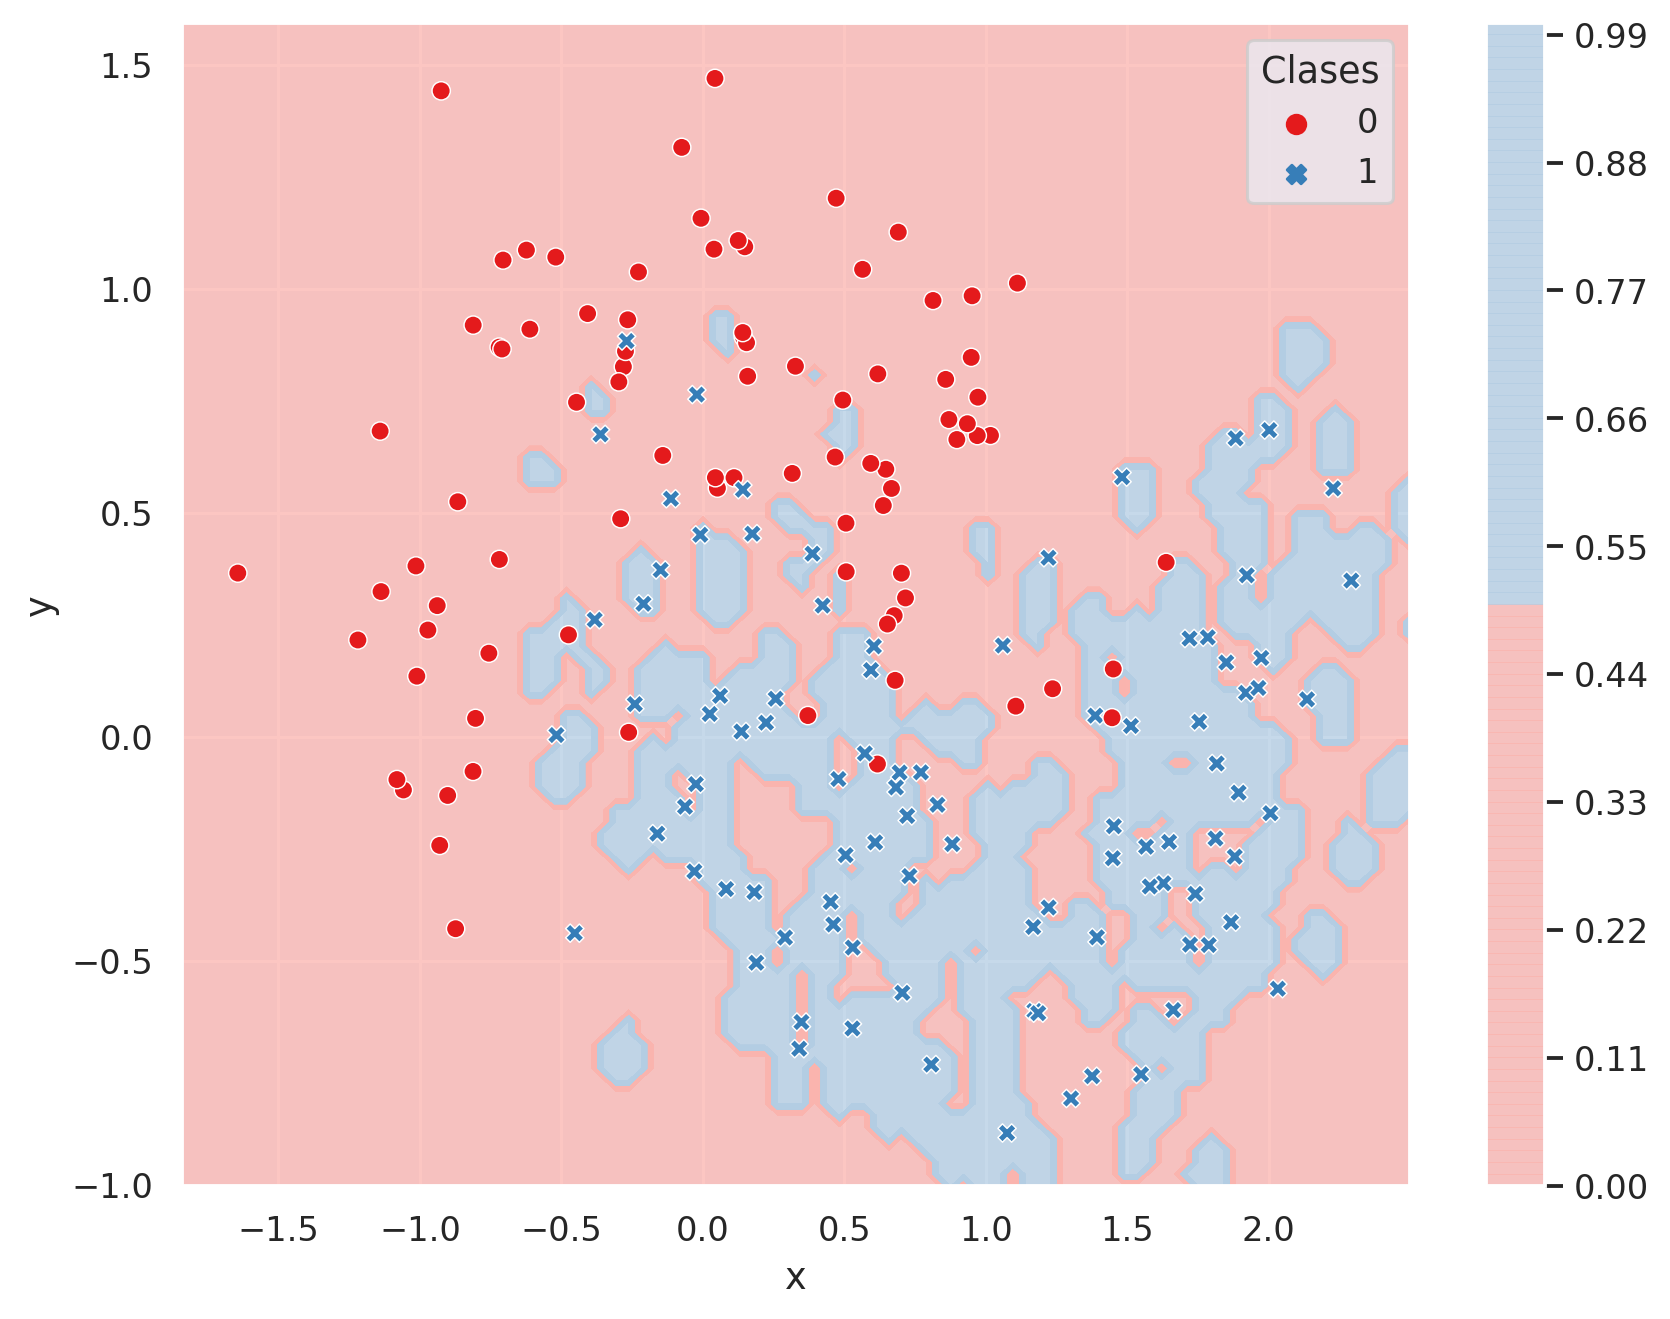

In [57]:
# Creamos y entrenamos el modelo.
rbf_svm = SVC(kernel='rbf', 
              gamma = 1000)
rbf_svm.fit(X_train_moons, y_train_moons)

# Graficamos los resultados.
plot_data(X_test_moons, y_test_moons, rbf_svm)

Ahora reportamos el error de entrenamiento y prueba:

In [58]:
print(f"Error en entrenamiento:\t{1-rbf_svm.score(X_train_moons, y_train_moons):.4f}")
print(f"Error en prueba:\t{1-rbf_svm.score(X_test_moons, y_test_moons):.4f}")

Error en entrenamiento:	0.0000
Error en prueba:	0.2278


La forma ha mejorado, pero ahora tenemos franjas de la clase $0$ ocupando el espacio que debería corresponder a la clase $1$, es decir, el modelo está **sobreajustado**. Probemos ahora con un valor de $\gamma$ intermedio:

In [59]:
# Creamos y entrenamos el modelo.
rbf_svm = SVC(kernel='rbf', 
              gamma = 0.7)
rbf_svm.fit(X_train_moons, y_train_moons)

# Graficamos los resultados.
plot_data(X_test_moons, y_test_moons, rbf_svm)

In [60]:
print(f"Error en entrenamiento:\t{1-rbf_svm.score(X_train_moons, y_train_moons):.4f}")
print(f"Error en prueba:\t{1-rbf_svm.score(X_test_moons, y_test_moons):.4f}")

Error en entrenamiento:	0.0881
Error en prueba:	0.1444


Probamos el mismo *kernel* sobre el conjunto de datos *Iris*:

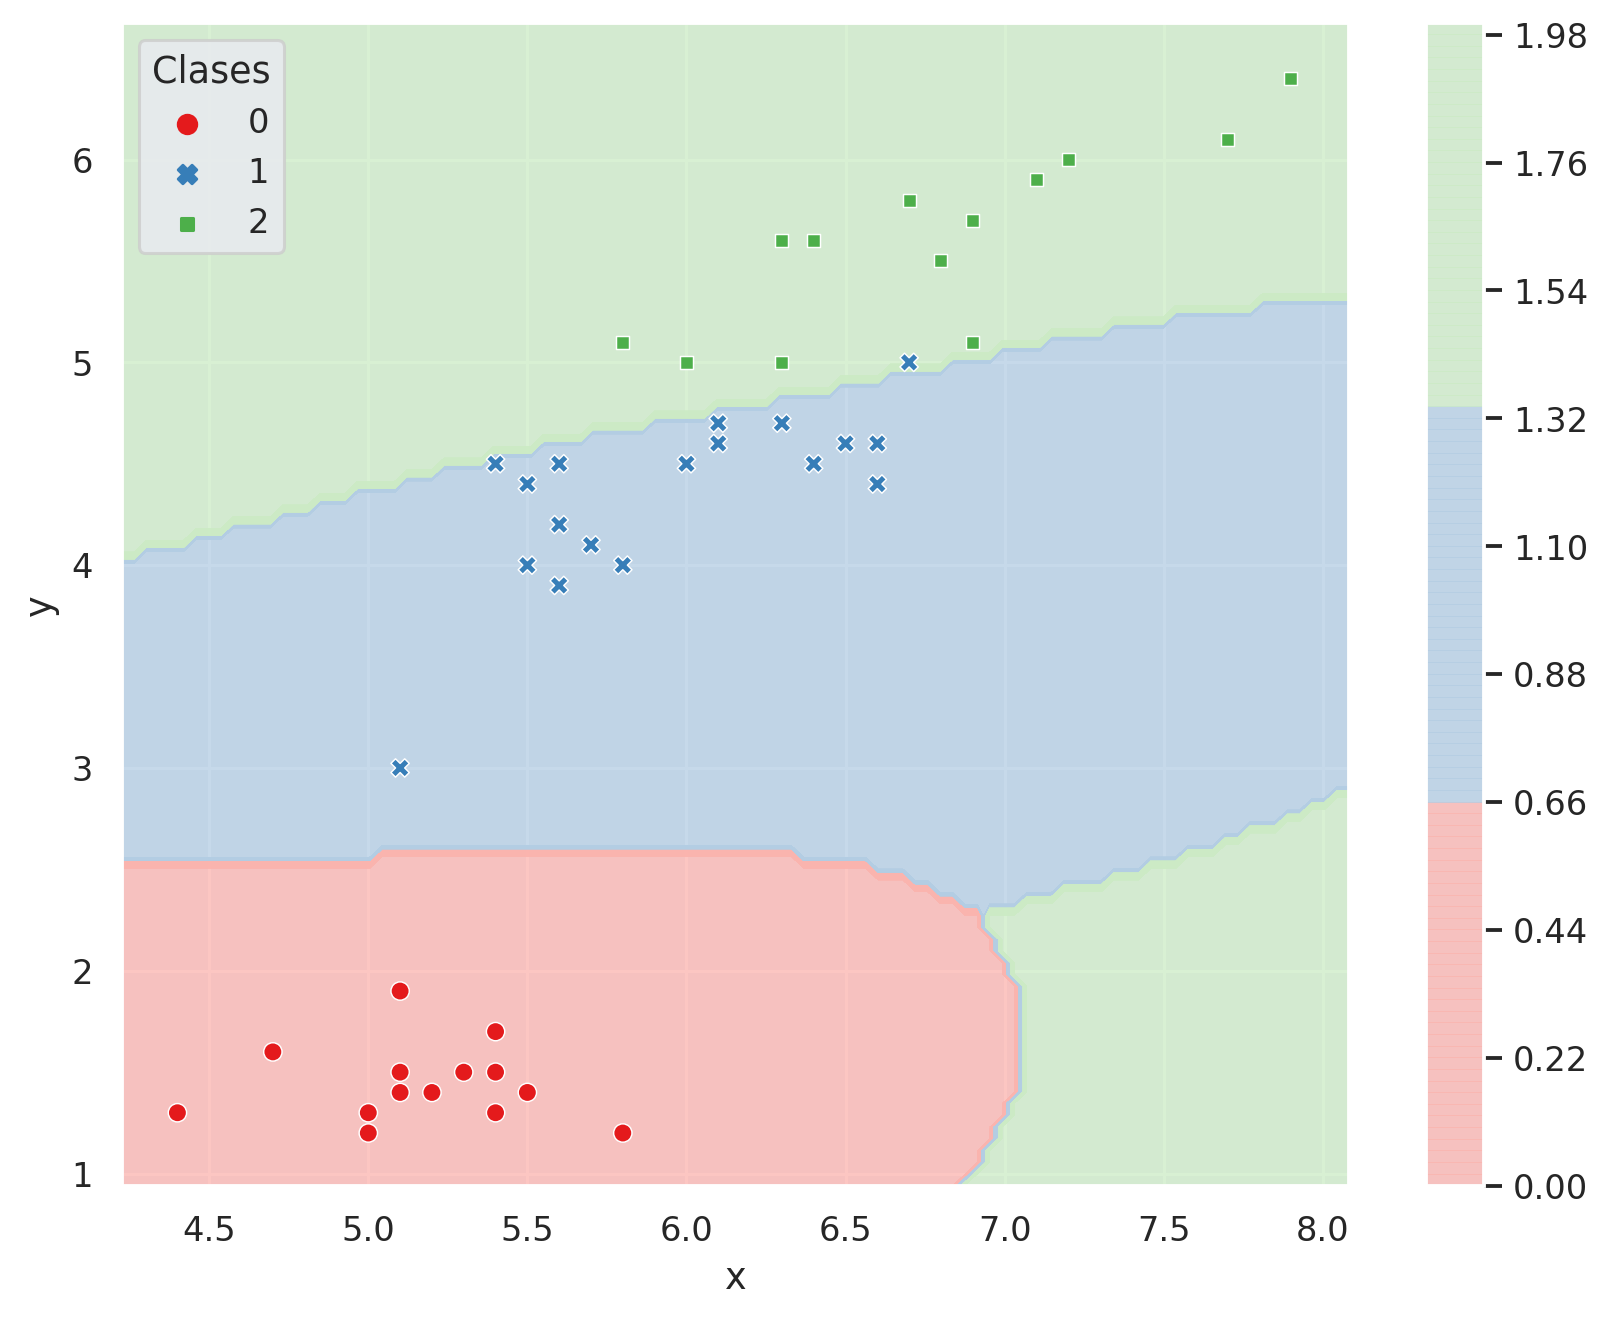

In [61]:
rbf_svm = SVC(kernel='rbf', gamma = 0.7)
rbf_svm.fit(X_train_iris, y_train_iris)

plot_data(X_test_iris, y_test_iris, rbf_svm)

Finalmente reportamos el error en entrenamiento y prueba:

In [62]:
print(f"Error en entrenamiento:\t{1-rbf_svm.score(X_train_iris, y_train_iris):.4f}")
print(f"Error en prueba:\t{1-rbf_svm.score(X_test_iris, y_test_iris):.4f}")

Error en entrenamiento:	0.0286
Error en prueba:	0.0222


# **5. Estimación de los hiperparámetros del modelo**
---

Hasta el momento nos hemos concentrado en evaluar nuestros modelos en una partición de prueba. Sin embargo, es común introducir sobreajuste a través de la modificación manual de los hiperparámetros de un modelo conforme vamos reportando el error de generalización sobre el conjunto de prueba.

<img src="https://drive.google.com/uc?export=view&id=1brLudEu094L7H3-cFqnrIRZnDrFIfrNW">

En la anterior imagen, introducimos una nueva partición, adicional a la de prueba y entrenamiento, conocida como partición de "**validación**". Esta partición es resultado de tomar la partición de entrenamiento y volver a dividirla (en entrenamiento y validación) de tal forma que cualquier configuración de parámetros que se use para entrenar un modelo, pueda ser reportada en **validación**. Una vez estemos seguros de que tenemos el modelo con el mejor desempeño en **validación**, volvemos a unir ambas particiones, entrenamos un modelo sobre la partición original de entrenamiento y reportamos **una sola vez** en el conjunto de prueba.

## **5.1. Validación cruzada de  $k$ pliegues**
---

A pesar de que se introdujo una nueva partición para validar los parámetros de un modelo, se sigue usando una partición reducida para entrenar el conjunto de datos. La **validación cruzada** nos permite usar una mayor parte de los datos para construír el modelo y generar un estimador más robusto y con mayor capacidad de generalización. En validación cruzada, los datos son particionados varias veces en entrenamiento y validación de forma repetida. Finalmente, el desempeño del clasificador es agregado sobre las diferentes particiones de validación para obtener un estimador más robusto.

La validación cruzada se hace comúnmente de la siguiente manera:
1. Se divide el conjunto de entrenamiento en $k$ pliegues o particiones (usualmente 3, 5 o 10). Estas particiones deben ser del mismo tamaño.
2. En cada iteración, uno de los pliegues es usado como la partición de validación, mientras el resto es usado como la partición de entrenamiento.
3. Se reporta y guarda el desempeño sobre esa partición de validación.

<img src="https://drive.google.com/uc?export=view&id=12nCvyPDNOgHuxpToJrlR-m71nt3SOrKo">

### **5.1.1. Validación cruzada usando *Scikit-Learn***
---

*Scikit-Learn* provee una implementación muy eficiente para realizar **validación cruzada** usando métodos del módulo **`sklearn.model_selection`**. El método **`sklearn.model_selection.cross_val_score`** recibe un estimador y un conjunto de datos, luego hace el particionamiento y entrena un modelo sobre cada partición de validación.

In [63]:
X_iris = iris.data
y_iris = iris.target

classifier_iris  = LinearSVC()

El parámetro **`cv`** en **`cross_val_score`** controla el número de pliegues a usar.

In [64]:
# Desempeño por validación cruzada.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier_iris, 
                         X_iris, 
                         y_iris, 
                         cv = 5)

In [65]:
print(f'Accuracy por cada pliegue:\n{list(scores)}')
print(f'Accuracy promedio sobre los 5 pliegues: {np.mean(scores)}')

Accuracy por cada pliegue:
[1.0, 1.0, 0.9333333333333333, 0.9, 1.0]
Accuracy promedio sobre los 5 pliegues: 0.9666666666666668


**`cross_val_score`** realiza por defecto una partición estratificada usando **`sklearn.model_selection.StratifiedKFold`**. Esta estrategia consiste en hacer un particionamiento de tal forma que cada partición tenga la misma distribución de etiquetas $y$.

En caso de que se quiera hacer una partición diferente, se puede especificar como argumento **`cv`** otro modelo de validación cruzada. Por ejemplo, si no queremos hacer partición estratificada podemos usar el constructor **`sklearn.model_selection.KFold`**.


Una vez declarado un objeto de tipo **`KFold`**, podemos usar el método **`split`** para iterar por los índices de las particiones $X$ y $y$ para cada pliegue autogenerado.

A continuación, agregaremos el conteo de clases por cada pliegue y obtendremos el *score* obtenido mediante el método **`cross_val_score`**.


In [66]:
# Validación cruzada de K-pliegues.
from sklearn.model_selection import KFold, StratifiedKFold 
n_folds = 5   # Definimos un total de 5 pliegues.

cv_no_stra = KFold(n_splits= n_folds)

X = iris.data
y = iris.target

pd.DataFrame(# Conteo de valores por clase. Por los índices de cada pliegue generado.
              [np.bincount(y[y_index], minlength = 3)          
              for X_index, y_index  in cv_no_stra.split(X, y)] 
              # Renombramos los índices (pliegues) y columnas (clases). 
              ).rename(index = lambda x: f'Pliegue {x}',     
                        columns = lambda x: f'Clase {x}'
              # Creamos una columna para almacenar el accuracy obtenido en cada pliegue.
              ).assign(accuracy = cross_val_score(classifier_iris, X_iris, y_iris, cv=cv_no_stra))

Clase 0  Clase 1  Clase 2  accuracy
Pliegue 0       30        0        0  1.000000
Pliegue 1       20       10        0  1.000000
Pliegue 2        0       30        0  0.666667
Pliegue 3        0       10       20  0.966667
Pliegue 4        0        0       30  0.666667

## **5.2. Validación cruzada con *Grid Search***
---

Los modelos *SVM* que usan *RBF* comúnmente requieren el ajuste de los parámetros **`gamma`** (coeficiente $\gamma$ del *kernel*) y **`C`** (parámetro de regularización.

Ambos parámetros controlan la complejidad del modelo. Estos parámetros pueden ser explorados usando un retículo (grid) de valores y evaluando su desempeño usando validación cruzada de $k$ pliegues. A continuación, creamos una partición de entrenamiento y prueba sobre el conjunto de datos *Iris*.


In [70]:
#@markdown **Video: Experimento con *Grid Search***
from IPython.display import HTML

HTML('<iframe style="width:768px; height: 432px;" src="https://drive.google.com/file/d/15LLpIS-OdeijeMCNmW0NSa56uhp3FQAj/preview"></iframe>')

In [67]:
# Partición estratíficada del conjunto de datos Iris.
X_train, X_test, y_train, y_test = train_test_split(X_iris, 
                                                    y_iris, 
                                                    test_size=0.3, 
                                                    random_state=1,
                                                    stratify=y_iris)

Definimos los siguientes valores para $C$ y $\textit{gamma}$. Vamos a explorar estos valores en el siguiente rango de potencias de 2:

> $2^{-5}, 2^{-4}, \dots , 2^{6}, 2^{7} $

In [68]:
# Los hiperparámetros deben estar en forma de diccionario.
param_grid = {'C':     [2**i for i in range(-5, 7, 1)], 
              'gamma': [2**i for i in range(-5, 7, 1)]}

param_grid

{'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64],
 'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]}

Valores de $C$:

In [69]:
print(param_grid['C'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


Valores de $\textit{gamma}$:

In [70]:
print(param_grid['gamma'])

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]


Podemos realizar una validación cruzada con *grid search* en los hiperparámetros e identificar la configuración con el mejor *score* utilizando el método **`sklearn.model_selection.GridSearchCV`**. El objeto retornado por este método funciona como los demás modelos e implementa funciones como **`fit`**, **`score`** y **`predict`**.

**`GridSearchCV`** recibe tres argumentos principales:
* **`estimator`**: modelo de *Scikit-Learn* a explorar. En este ejemplo usaremos  **`SVC(kernel='rbf')`**.
* **`param_grid`**: diccionario que contiene los parámetros que se van a explorar usando validación cruzada. La llave del diccionario es el nombre del parámetro y el valor es una lista con los valores que se quieren explorar.
* **`return_train_score`**: si se ingresa como argumento el valor **`True`**, los puntajes o *scores* de los modelos entrenados en cada combinación aparecerán en el objeto del atributo **`cv_results_`**.

In [71]:
# Búsqueda en cuadrícula de hiperparámetros.
from sklearn.model_selection import GridSearchCV 

grid_clf = GridSearchCV(SVC(kernel='rbf'), 
                   param_grid=param_grid, 
                   verbose=1, 
                   return_train_score=True
                   )

grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64],
                         'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32, 64]},
             return_train_score=True, verbose=1)

**`GridSearchCV`** nos ofrece una serie de atributos y métodos que nos permiten consultar:
* La lista de resultados por elemento en la malla de parámetros(**`cv_results_`**).
* La configuración con el mejor desempeño (**`best_params_`**).
* El *accuracy* promedio sobre todos los pliegues de la mejor configuración(**`best_score_`**).

Los valores promedio de *accuracy* para cada combinación de hiperparámetros se pueden extraer usando **`GridSearchCV.cv_results_`**. Para visualizarlo mejor convertimos ese diccionario a un *DataFrame* de *Pandas*.

In [72]:
cv_results = pd.DataFrame(grid_clf.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0         0.001532      0.001023         0.000530        0.000190  0.03125   
1         0.001032      0.000088         0.000517        0.000130  0.03125   
2         0.001004      0.000022         0.000447        0.000022  0.03125   
3         0.001017      0.000012         0.000443        0.000006  0.03125   
4         0.001202      0.000395         0.000534        0.000129  0.03125   
..             ...           ...              ...             ...      ...   
139       0.001056      0.000045         0.000399        0.000041       64   
140       0.001094      0.000012         0.000423        0.000049       64   
141       0.001111      0.000019         0.000417        0.000016       64   
142       0.001163      0.000067         0.000447        0.000053       64   
143       0.001145      0.000016         0.000434        0.000012       64   

    param_gamma                            params  split0_test_score  \
0       0.03125  {'C': 0.03125, 'gamma': 0.03125}           0.904762   
1        0.0625   {'C': 0.03125, 'gamma': 0.0625}           0.904762   
2         0.125    {'C': 0.03125, 'gamma': 0.125}           0.904762   
3          0.25     {'C': 0.03125, 'gamma': 0.25}           0.904762   
4           0.5      {'C': 0.03125, 'gamma': 0.5}           0.952381   
..          ...                               ...                ...   
139           4             {'C': 64, 'gamma': 4}           0.904762   
140           8             {'C': 64, 'gamma': 8}           0.857143   
141          16            {'C': 64, 'gamma': 16}           0.714286   
142          32            {'C': 64, 'gamma': 32}           0.619048   
143          64            {'C': 64, 'gamma': 64}           0.476190   

     split1_test_score  split2_test_score  ...  mean_test_score  \
0             1.000000           0.809524  ...         0.914286   
1             1.000000           0.809524  ...         0.923810   
2             1.000000           0.809524  ...         0.923810   
3             1.000000           0.809524  ...         0.914286   
4             1.000000           0.809524  ...         0.923810   
..                 ...                ...  ...              ...   
139           0.904762           0.904762  ...         0.895238   
140           0.904762           0.904762  ...         0.895238   
141           0.857143           0.761905  ...         0.809524   
142           0.761905           0.666667  ...         0.714286   
143           0.571429           0.619048  ...         0.590476   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0          0.063174               71            0.916667            0.916667   
1          0.071270               52            0.916667            0.916667   
2          0.071270               52            0.916667            0.916667   
3          0.063174               71            0.916667            0.928571   
4          0.064594               52            0.952381            0.928571   
..              ...              ...                 ...                 ...   
139        0.019048               90            1.000000            1.000000   
140        0.019048               90            1.000000            1.000000   
141        0.060234              105            1.000000            1.000000   
142        0.067344              122            1.000000            1.000000   
143        0.077372              128            1.000000            1.000000   

     split2_train_score  split3_train_score  split4_train_score  \
0              0.940476            0.916667            0.916667   
1              0.940476            0.928571            0.916667   
2              0.940476            0.940476            0.928571   
3              0.940476            0.940476            0.964286   
4              0.964286            0.964286            0.952381   
..                  ...            

Para encontrar las mejores configuraciones, podemos obtener la tabla de los $n$ mayores resultados con *pandas*. 
> El método **`nlargest`** es un método de los objetos *DataFrame* de *pandas* que permite retornar las $n$ observaciones con mayor valor en la variable deseada. En este caso esa variable es el puntaje del modelo **`mean_test_score`**.

In [73]:
# Método nlargest de pandas, con los 10 primeros valores por mean_test_score.
cv_results.nlargest(10, 'mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
65        0.000760      0.000021         0.000346        0.000005       1   
76        0.000988      0.000564         0.000373        0.000024       2   
97        0.000627      0.000027         0.000334        0.000009       8   
108       0.000633      0.000042         0.000346        0.000023      16   
52        0.000707      0.000006         0.000368        0.000002     0.5   
53        0.000741      0.000010         0.000396        0.000045     0.5   
54        0.000842      0.000011         0.000364        0.000006     0.5   
63        0.000826      0.000139         0.000447        0.000107       1   
73        0.000800      0.000150         0.000552        0.000120       2   
74        0.000656      0.000030         0.000361        0.000029       2   

    param_gamma                       params  split0_test_score  \
65            1         {'C': 1, 'gamma': 1}           1.000000   
76          0.5       {'C': 2, 'gamma': 0.5}           1.000000   
97       0.0625    {'C': 8, 'gamma': 0.0625}           1.000000   
108     0.03125  {'C': 16, 'gamma': 0.03125}           1.000000   
52          0.5     {'C': 0.5, 'gamma': 0.5}           0.952381   
53            1       {'C': 0.5, 'gamma': 1}           1.000000   
54            2       {'C': 0.5, 'gamma': 2}           1.000000   
63         0.25      {'C': 1, 'gamma': 0.25}           0.952381   
73       0.0625    {'C': 2, 'gamma': 0.0625}           0.952381   
74        0.125     {'C': 2, 'gamma': 0.125}           0.952381   

     split1_test_score  split2_test_score  ...  mean_test_score  \
65            0.952381           0.952381  ...         0.961905   
76            0.952381           0.952381  ...         0.961905   
97            0.952381           0.952381  ...         0.961905   
108           0.952381           0.952381  ...         0.961905   
52            1.000000           0.904762  ...         0.952381   
53            0.952381           0.952381  ...         0.952381   
54            0.952381           0.952381  ...         0.952381   
63            1.000000           0.904762  ...         0.952381   
73            1.000000           0.904762  ...         0.952381   
74            1.000000           0.904762  ...         0.952381   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
65         0.035635                1            0.976190            0.976190   
76         0.035635                1            0.976190            0.976190   
97         0.035635                1            0.964286            0.976190   
108        0.035635                1            0.964286            0.976190   
52         0.030117                5            0.964286            0.952381   
53         0.030117                5            0.952381            0.976190   
54         0.030117                5            0.976190            0.976190   
63         0.030117                5            0.964286            0.952381   
73         0.030117                5            0.964286            0.964286   
74         0.030117                5            0.964286            0.952381   

     split2_train_score  split3_train_score  split4_train_score  \
65             0.976190            0.976190            0.976190   
76             0.976190            0.976190            0.976190   
97             0.964286            0.976190            0.964286   
108            0.964286            0.976190            0.964286   
52             0.964286            0.988095            0.964286   
53             0.964286            0.976190            0.964286   
54             0.976190            0.988095            0.976190   
63             0.964286            0.988095            0.964286   
73             0.952381            0.988095            0.964286   
74             0.964286            0.976190            0.964286   

     mean_train_score  std_train_score  
65           0.976190

En este caso la configuración con $C = 1$ y $\gamma = 1$ es la que aparece como mayor puntaje, empatada con otra configuración con $C = 2$ y $\gamma = 0.25$. Esta información también se puede consultar usando **`.best_params_`** y **`.best_score_`**.

In [74]:
# Mejores parámetros identificados.
print(grid_clf.best_params_)

{'C': 1, 'gamma': 1}


In [75]:
# Puntaje de la mejor combinación de parámetros.
print(grid_clf.best_score_)

0.9619047619047618


Una vez se haya entrenado el modelo usando validación cruzada, **`GridSearchCV`** escoge automáticamente la mejor configuración y vuelve a entrenar un modelo sobre todo el conjunto de datos de entrenamiento. Por lo tanto tras realizar el entrenamiento con **`fit`** se pueden hacer llamados a funciones como **`predict()`** y **`score()`** directamente desde el objeto de *grid search*.

Para reportar sobre el conjunto de prueba basta con ejecutar:

In [76]:
grid_clf.score(X_test, y_test)

0.9777777777777777

A continuación, vamos a explorar gráficamente los resultados obtenidos en todas las configuraciones. Primero observamos que el número de filas del *DataFrame*  **`cv_results`** corresponde al número de configuraciones de hiperparámetros que se están explorando:

In [77]:
len(cv_results), len(param_grid['C']) * len(param_grid['gamma'])

(144, 144)

Usando la columna **`mean_test_score`**, extraemos los valores de precisión o *accuracy* promedio y los organizamos en una matriz donde las filas corresponden a los valores del parámetro **`C`** y las columnas a los valores del parámetro **`gamma`**. 

Para esto, usaremos el método **`pivot`** de *pandas* que genera una [tabla de pivote](https://en.wikipedia.org/wiki/Pivot_table).

In [78]:
scores_df = cv_results.pivot(index = 'param_C',
                             columns = 'param_gamma', 
                             values = 'mean_test_score')
scores_df 

param_gamma  0.03125   0.06250   0.12500   0.25000   0.50000   1.00000   \
param_C                                                                   
0.03125      0.914286  0.923810  0.923810  0.914286  0.923810  0.933333   
0.06250      0.914286  0.923810  0.923810  0.914286  0.923810  0.933333   
0.12500      0.914286  0.923810  0.914286  0.923810  0.933333  0.942857   
0.25000      0.923810  0.914286  0.942857  0.914286  0.942857  0.942857   
0.50000      0.914286  0.942857  0.923810  0.942857  0.952381  0.952381   
1.00000      0.942857  0.933333  0.942857  0.952381  0.942857  0.961905   
2.00000      0.933333  0.952381  0.952381  0.942857  0.961905  0.942857   
4.00000      0.952381  0.952381  0.952381  0.952381  0.942857  0.933333   
8.00000      0.952381  0.961905  0.952381  0.952381  0.942857  0.923810   
16.00000     0.961905  0.952381  0.952381  0.942857  0.914286  0.933333   
32.00000     0.952381  0.952381  0.933333  0.923810  0.914286  0.933333   
64.00000     0.952381  0.942857  0.923810  0.923810  0.923810  0.923810   

param_gamma  2.00000   4.00000   8.00000   16.00000  32.00000  64.00000  
param_C                                                                  
0.03125      0.914286  0.885714  0.771429  0.714286  0.571429  0.476190  
0.06250      0.914286  0.885714  0.771429  0.714286  0.571429  0.476190  
0.12500      0.914286  0.885714  0.771429  0.714286  0.571429  0.476190  
0.25000      0.914286  0.914286  0.780952  0.714286  0.571429  0.476190  
0.50000      0.952381  0.923810  0.857143  0.752381  0.571429  0.476190  
1.00000      0.942857  0.914286  0.895238  0.800000  0.733333  0.542857  
2.00000      0.933333  0.904762  0.895238  0.809524  0.714286  0.590476  
4.00000      0.933333  0.904762  0.895238  0.809524  0.714286  0.590476  
8.00000      0.933333  0.895238  0.895238  0.809524  0.714286  0.590476  
16.00000     0.933333  0.895238  0.895238  0.809524  0.714286  0.590476  
32.00000     0.923810  0.895238  0.895238  0.809524  0.714286  0.590476  
64.00000     0.923810  0.895238  0.895238  0.809524  0.714286  0.590476

A continuación, presentamos una forma de visualizar esta exploración sobre la malla de hiperparámetros en forma de mapa de calor con el método **`heatmap`** de *Seaborn*, una librería de visualización de datos estadísticos.

In [79]:
sns.heatmap(scores_df, cmap = 'inferno').set_title('Accuracy en validación');

#**Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* en la creación y entrenamiento de modelos de clasificación de lineal, validación cruzada y búsqueda de hiperparámetros, además de material de apoyo teórico para reforzar estos conceptos:

* [mlcourse.ai - Topic 3. Classification, Decision Trees and k Nearest Neighbors](https://mlcourse.ai/articles/topic3-dt-knn/)
* [Curso de aprendizaje automático para el INE- Support Vector Machines](http://albertotb.com/curso-ml-R/Rmd/07-svm/07-svm.html#1)
* [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/)
* [scikit-learn - 3.2.1. Exhaustive Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)




# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:** 
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*